## Introduction


In this jupyter notebook we will predict the 2018 nba playoffs bracket results using neural networks models fit to regular season stats.

Predicting the bracket boils down to determining who will win a given playoff series. We do this using two different methods. 

1. First, we just look at the regular season stats per game for each team in a matchup. The predictor we consider is the difference vector of regular season stats from each team. (e.g. Team1 =  pd.Series({'PTS': 112, 'FG%':0.52, 'BLK': 1.7}), Team1 =  pd.Series({'PTS': 123.5, 'FG%':0.42, 'BLK': 2.3}), vec = [-11.5,-0.10,0.5]).

2. Second method is to choose our predictor to be a 2-dimensional array. We simply take an array consisting of both team stats in a matchup (e.g. Team1 =  pd.Series({'PTS': 112, 'FG%':0.52, 'BLK': 1.7}), Team1 =  pd.Series({'PTS': 123.5, 'FG%':0.42, 'BLK': 2.3}), 2_tensor = [[112, 0.52, 1.7],[123.5,0.42,2.3]]).


The strategy here is to predict the win differential instead of whether team 1 or team 2 wins; this creates a larger margin for error; for example, if we predict the win differential of team 1 over team 2 to be 2 when the actual score line is 4-1, we still predict correctly team 1 beats team 2.

The sign of the win differential is significant here. For instance, if we predict team 1 beats team 2 in a playoff series with a score of 4-2 the win differential is 2 while if team 1 loses to team 2 with the same score line the win differential is -2. So the win differential will tell us which team is victorious. We choose two different kinds of neural networks to accomplish this:

1. Multilayer Perceptron
2. Convolutional Neural Network

corresponding to methods 1 and 2, as mentioned earlier.


Let's load some packages and write some helper functions.

## Data Scraping and Cleaning 

In [1]:
#Let's first import some libraries we will use to scrape and clean data.


%matplotlib inline
from selenium import webdriver
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

In [2]:
#helper function to determine a string is numeric or not
def is_numeric(n):
    try:
        float(n)
        return True
    except ValueError:
        pass
    return False


In [3]:
#write function that will return a list of pairs (result, reg_stat)

def season_and_result(year):
    
    url = 'https://www.basketball-reference.com/leagues/NBA_' + year + '.html'
    temp_browser = webdriver.Chrome('chromedriver')
    temp_browser.get(url)

    temp_string = '//*[@id="all_team-stats-per_game"]/div[3]'
    temp_table = temp_browser.find_element_by_xpath(temp_string)
    
    teamNames = []
    columns = []
    listOfVal = []
    listOfCol = []
    dictionary = {}

    for index, line in enumerate(temp_table.text.split('\n')):
        if index == 0:
            columns = line.split(" ")
            columns = [name for name in columns if name != 'Team']
        else:
            current = line.split(" ")
            
            #concatenate to retrieve team names
            temp_name = [entry for entry in current if not is_numeric(entry)]

            teamNames.append(" ".join(temp_name))
            current = [float(entry) for entry in current if is_numeric(entry)]

            listOfVal.append(current)

    #rearrange listOfVal so that we have column values as lists

    #delete league average row
    del listOfVal[-1]
    del teamNames[-1]
    

    #need to extract names from result table
    if "Charlotte Hornets" in teamNames and year == "2014":
        key = teamNames.index("Charlotte Hornets")
        teamNames[key] = "Charlotte Bobcats"
   
    for i in range(len(listOfVal[0])):
        listOfCol.append([lis[i] for lis in listOfVal])

    #add values to dictionary from listOfCol
    for i in range(len(columns)):
        dictionary[columns[i]] = listOfCol[i]
    

    #determine result for teams
    final_result = pd.DataFrame(dictionary)
    
    #let's drop the number of games
    final_result = final_result.drop(['G'], axis = 1)
    
    #add team name
    final_result['Team'] = teamNames
    
    #let's just include teams that made it to the playoffs
    final_result = final_result[final_result['Team'].str.endswith('*')]
    
    #now remove the asterisk at the end
    final_result['Team'] = final_result['Team'].apply(lambda x: x[:-1])
    final_result.reset_index(drop = True, inplace = True)
    
    
    columns = list(final_result.columns)

    #rearrange columns so that team comes first
    newcolumns = [columns[-1]] + columns[:-1]
    newcolumns = ['Team','MP','FG','FGA','FG%','3P','3PA','3P%','2P','2PA','2P%',
                 'FT','FTA','FT%','ORB','DRB','TRB','AST','STL','BLK','TOV',
                 'PF','PTS']
    
    
    
    final_result = final_result[newcolumns]   
    
    
    
    
    #generate dataframe for playoffs results
    
    result_string = '//*[@id="all_all_playoffs"]/div[3]'
    result_table = temp_browser.find_element_by_xpath(result_string)
    playoff_results = result_table.text.split('\n')
    #teamNames = list(reg_team_pg_stats(year)['Team'])
    
    win_list = []
    los_list = []
    score_list = []
    round_list = []
    
    for idx, row in enumerate(playoff_results):
        line = playoff_results[idx].split(" ")
        
        startW = 0
        endW = 0
        
        startL = 0
        endL = 0
        
        indexR = 0
        
        winner = ''
        loser = ''
        score = ''
        rnd = ''
        
        #find the start index
        
        if 'Finals' in line:
            startW = line.index('Finals')
           
        elif 'Round' in line:
            startW = line.index('Round')
            
        else:
            startW = line.index('Semifinals')
             
        if 'over' in line:
            endW = line.index('over')
            startL = endW
        
        
        ser = pd.Series(line)
        
        bool_ser = ser.str.contains('(', regex = False)
        
        endL = bool_ser[bool_ser == True].index[0]
        
        winner = " ".join(line[startW + 1: endW])
        loser = " ".join(line[startL + 1 : endL - 1])
        rnd = " ".join(line[: startW+1])
        
        score = line[endL]
     
        win_list.append(winner)
        los_list.append(loser)
        score_list.append(score)
        round_list.append(rnd)
        
    result = pd.DataFrame({'Year': [year]*15 ,'Team1': win_list, 'Team2': los_list, 
                         'Score' : score_list, 'Round' : round_list})
    result = result[['Year','Round','Team1', 'Team2', 'Score']]
    playoff_res = result
    reg_stat_res = final_result
      
    return (playoff_res, reg_stat_res)


In [4]:
#write function that will return a list of pairs (result, reg_stat)
#normalize stats columns using the preprocessing library from sklearn

def season_and_result_norm(year):
    
    url = 'https://www.basketball-reference.com/leagues/NBA_' + year + '.html'
    temp_browser = webdriver.Chrome('chromedriver')
    temp_browser.get(url)

    temp_string = '//*[@id="all_team-stats-per_game"]/div[3]'
    temp_table = temp_browser.find_element_by_xpath(temp_string)
    
    teamNames = []
    columns = []
    listOfVal = []
    listOfCol = []
    dictionary = {}

    for index, line in enumerate(temp_table.text.split('\n')):
        if index == 0:
            columns = line.split(" ")
            columns = [name for name in columns if name != 'Team']
        else:
            current = line.split(" ")
            
            #concatenate to retrieve team names
            temp_name = [entry for entry in current if not is_numeric(entry)]

            teamNames.append(" ".join(temp_name))
            current = [float(entry) for entry in current if is_numeric(entry)]

            listOfVal.append(current)

    #rearrange listOfVal so that we have column values as lists

    #delete league average row
    del listOfVal[-1]
    del teamNames[-1]
    

    #need to extract names from result table
    if "Charlotte Hornets" in teamNames and year == "2014":
        key = teamNames.index("Charlotte Hornets")
        teamNames[key] = "Charlotte Bobcats"
   
    for i in range(len(listOfVal[0])):
        listOfCol.append([lis[i] for lis in listOfVal])

    #add values to dictionary from listOfCol
    for i in range(len(columns)):
        dictionary[columns[i]] = listOfCol[i]
    

    #determine result for teams
    final_result = pd.DataFrame(dictionary)
    
    #let's drop the number of games
    final_result = final_result.drop(['G'], axis = 1)
    
    #add team name
    final_result['Team'] = teamNames
    
    #let's just include teams that made it to the playoffs
    final_result = final_result[final_result['Team'].str.endswith('*')]
    
    #now remove the asterisk at the end
    final_result['Team'] = final_result['Team'].apply(lambda x: x[:-1])
    final_result.reset_index(drop = True, inplace = True)
    
    
    columns = list(final_result.columns)

    #rearrange columns so that team comes first
    newcolumns = [columns[-1]] + columns[:-1]
    newcolumns = ['Team','MP','FG','FGA','FG%','3P','3PA','3P%','2P','2PA','2P%',
                 'FT','FTA','FT%','ORB','DRB','TRB','AST','STL','BLK','TOV',
                 'PF','PTS']
    
    numeric_col = ['MP','FG','FGA','FG%','3P','3PA','3P%','2P','2PA','2P%',
                 'FT','FTA','FT%','ORB','DRB','TRB','AST','STL','BLK','TOV',
                 'PF','PTS']
    
    final_result = final_result[newcolumns]   
    
    to_normalize = final_result[numeric_col]
    
    std_scale = preprocessing.StandardScaler().fit(to_normalize)
    
    normalized = std_scale.transform(to_normalize)
    
    normalized_col = pd.DataFrame(normalized, index = to_normalize.index,
                                 columns = to_normalize.columns)
    
    final_result.update(normalized_col)
    
    
    
    #generate dataframe for playoffs results
    
    result_string = '//*[@id="all_all_playoffs"]/div[3]'
    result_table = temp_browser.find_element_by_xpath(result_string)
    playoff_results = result_table.text.split('\n')
    #teamNames = list(reg_team_pg_stats(year)['Team'])
    
    win_list = []
    los_list = []
    score_list = []
    round_list = []
    
    for idx, row in enumerate(playoff_results):
        line = playoff_results[idx].split(" ")
        
        startW = 0
        endW = 0
        
        startL = 0
        endL = 0
        
        indexR = 0
        
        winner = ''
        loser = ''
        score = ''
        rnd = ''
        
        #find the start index
        
        if 'Finals' in line:
            startW = line.index('Finals')
           
        elif 'Round' in line:
            startW = line.index('Round')
            
        else:
            startW = line.index('Semifinals')
             
        if 'over' in line:
            endW = line.index('over')
            startL = endW
        
        
        ser = pd.Series(line)
        
        bool_ser = ser.str.contains('(', regex = False)
        
        endL = bool_ser[bool_ser == True].index[0]
        
        winner = " ".join(line[startW + 1: endW])
        loser = " ".join(line[startL + 1 : endL - 1])
        rnd = " ".join(line[: startW+1])
        
        score = line[endL]
     
        win_list.append(winner)
        los_list.append(loser)
        score_list.append(score)
        round_list.append(rnd)
        
    result = pd.DataFrame({'Year': [year]*15 ,'Team1': win_list, 'Team2': los_list, 
                         'Score' : score_list, 'Round' : round_list})
    result = result[['Year','Round','Team1', 'Team2', 'Score']]
    playoff_res = result
    reg_stat_res = final_result
      
    return (playoff_res, reg_stat_res)


In [5]:
#test
season_result_2015 = season_and_result('2015')

In [6]:
#playoffs results in 2015
season_result_2015[0]

,Year,Round,Team1,Team2,Score
0,2015,Finals,Golden State Warriors,Cleveland Cavaliers,(4-2)
1,2015,Eastern Conference Finals,Cleveland Cavaliers,Atlanta Hawks,(4-0)
2,2015,Western Conference Finals,Golden State Warriors,Houston Rockets,(4-1)
3,2015,Eastern Conference Semifinals,Atlanta Hawks,Washington Wizards,(4-2)
4,2015,Eastern Conference Semifinals,Cleveland Cavaliers,Chicago Bulls,(4-2)
5,2015,Western Conference Semifinals,Golden State Warriors,Memphis Grizzlies,(4-2)
6,2015,Western Conference Semifinals,Houston Rockets,Los Angeles Clippers,(4-3)
7,2015,Eastern Conference First Round,Atlanta Hawks,Brooklyn Nets,(4-2)
8,2015,Eastern Conference First Round,Chicago Bulls,Milwaukee Bucks,(4-2)
9,2015,Eastern Conference First Round,Cleveland Cavaliers,Boston Celtics,(4-0)


In [7]:
#regular season stats in 2015
season_result_2015[1]

,Team,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Golden State Warriors,240.6,41.6,87.0,0.478,10.8,27.0,0.398,30.8,60.0,...,0.768,10.4,34.3,44.7,27.4,9.3,6.0,14.5,19.9,110.0
1,Los Angeles Clippers,240.6,39.4,83.3,0.473,10.1,26.9,0.376,29.3,56.4,...,0.710,9.6,33.1,42.6,24.8,7.8,5.0,12.3,21.3,106.7
2,Dallas Mavericks,242.4,39.7,85.8,0.463,8.9,25.4,0.352,30.8,60.4,...,0.752,10.5,31.8,42.3,22.5,8.1,4.5,13.0,20.0,105.2
3,Toronto Raptors,242.1,37.9,83.3,0.455,8.9,25.1,0.352,29.0,58.2,...,0.787,10.7,30.8,41.5,20.7,7.5,4.4,12.9,20.9,104.0
4,Houston Rockets,241.5,37.0,83.3,0.444,11.4,32.7,0.348,25.6,50.6,...,0.715,11.7,32.0,43.7,22.2,9.5,5.0,16.7,22.0,103.9
5,San Antonio Spurs,243.4,39.1,83.6,0.468,8.3,22.5,0.367,30.9,61.1,...,0.780,9.8,33.8,43.6,24.4,8.0,5.4,14.0,19.1,103.2
6,Cleveland Cavaliers,241.2,37.7,82.2,0.458,10.1,27.5,0.367,27.6,54.7,...,0.751,11.1,31.9,43.0,22.1,7.4,4.1,14.3,18.4,103.1
7,Portland Trail Blazers,242.1,38.7,86.0,0.450,9.8,27.2,0.362,28.9,58.8,...,0.801,10.7,35.1,45.9,21.9,6.4,4.5,13.6,18.2,102.8
8,Atlanta Hawks,240.6,38.1,81.7,0.466,10.0,26.2,0.380,28.1,55.5,...,0.778,8.7,31.8,40.6,25.7,9.1,4.6,14.2,17.8,102.5
9,Boston Celtics,242.4,38.9,87.9,0.443,8.0,24.6,0.327,30.9,63.3,...,0.754,11.1,32.7,43.8,24.5,8.2,3.6,13.8,21.2,101.4


In [8]:
season_result_2015_norm = season_and_result_norm('2015')

In [9]:
#let's write a helper method that generates the stats_vec values below

def stats_vec(winner, loser, reg_stats):
    
    wo_teamname = reg_stats

    win = wo_teamname[wo_teamname['Team'] == winner]
    los = wo_teamname[wo_teamname['Team'] == loser]
    
    new_dic = {}

    for col in list(win.columns):
        if col != 'Team':
            new_dic[col] = win[col].iloc[0] - los[col].iloc[0]

    diff_vec = pd.Series(new_dic)
    
    return diff_vec.values

In [10]:
#we will write a helper function that generates 2-tensors

def two_tensor(winner, loser, reg_stats):
    wo_teamname = reg_stats
    final_list = []

    win = wo_teamname[wo_teamname['Team'] == winner].drop(['Team'],axis = 1
                                                         ).values[0]
    los = wo_teamname[wo_teamname['Team'] == loser].drop(['Team'],axis = 1
                                                       ).values[0]
    
    return [win, los]

In [11]:
#let's write a method that generates the dataframe we will fit models to

def gen_train_data(results, reg_stats):
    #we initiate the dic where we will store our columns
    dic ={}
    
    #let's create the 1-tensor or stats_vec
    list_of_vec = []
    zip_ob =  zip(list(results['Team1']),list(results['Team2']))

    for tup in zip_ob:
        list_of_vec.append(stats_vec(*tup, reg_stats))

    dic['stats_vec'] = list_of_vec
    
    
    #also, the 2-tensor
    #let's add 2-tensor as a column to test it on a model
    zip_ob1 =  zip(list(results['Team1']),list(results['Team2']))
    list_of_vec1 = []
    for tup in zip_ob1:
        list_of_vec1.append(two_tensor(*tup, reg_stats))

    dic['2_tensor_vec'] = list_of_vec1
    
    #win differential
    #just use a lambda function
    dic['win_differential'] = results['Score'].apply(lambda x: int(x[1]) - int(x[3]))
    
    #year of playoffs
    dic['Year'] = results['Year']
    
    #round
    dic['Round'] = results['Round']
    
    #finally, the winner and loser columns
    dic['Team1'] = results['Team1']
    dic['Team2'] = results['Team2']
    
    final_df = pd.DataFrame(dic)
    final_df = final_df[['Year', 'Round','Team1','Team2','stats_vec','2_tensor_vec','win_differential']]

    return final_df
    
    

In [12]:
#test
train_data_2015 = gen_train_data(season_result_2015[0],season_result_2015[1])

train_data_2015

,Year,Round,Team1,Team2,stats_vec,2_tensor_vec,win_differential
0,2015,Finals,Golden State Warriors,Cleveland Cavaliers,"[3.1999999999999993, 0.010000000000000009, 5.2...","[[240.6, 41.6, 87.0, 0.478, 10.8, 27.0, 0.398,...",2
1,2015,Eastern Conference Finals,Cleveland Cavaliers,Atlanta Hawks,"[-0.5, -0.0020000000000000018, -0.799999999999...","[[241.2, 37.7, 82.2, 0.458, 10.1, 27.5, 0.367,...",4
2,2015,Western Conference Finals,Golden State Warriors,Houston Rockets,"[5.199999999999999, 0.008000000000000007, 9.39...","[[240.6, 41.6, 87.0, 0.478, 10.8, 27.0, 0.398,...",3
3,2015,Eastern Conference Semifinals,Atlanta Hawks,Washington Wizards,"[-4.100000000000001, 0.018000000000000016, -10...","[[240.6, 38.1, 81.7, 0.466, 10.0, 26.2, 0.38, ...",2
4,2015,Eastern Conference Semifinals,Cleveland Cavaliers,Chicago Bulls,"[-1.0999999999999979, 0.030000000000000027, -5...","[[241.2, 37.7, 82.2, 0.458, 10.1, 27.5, 0.367,...",2
5,2015,Western Conference Semifinals,Golden State Warriors,Memphis Grizzlies,"[-1.8000000000000007, 0.029000000000000026, -7...","[[240.6, 41.6, 87.0, 0.478, 10.8, 27.0, 0.398,...",2
6,2015,Western Conference Semifinals,Houston Rockets,Los Angeles Clippers,"[-3.6999999999999993, -0.013000000000000012, -...","[[241.5, 37.0, 83.3, 0.444, 11.4, 32.7, 0.348,...",1
7,2015,Eastern Conference First Round,Atlanta Hawks,Brooklyn Nets,"[-2.6999999999999993, 0.017000000000000015, -7...","[[240.6, 38.1, 81.7, 0.466, 10.0, 26.2, 0.38, ...",2
8,2015,Eastern Conference First Round,Chicago Bulls,Milwaukee Bucks,"[-2.3000000000000007, -0.01200000000000001, -3...","[[242.4, 36.6, 82.9, 0.442, 7.9, 22.3, 0.353, ...",2
9,2015,Eastern Conference First Round,Cleveland Cavaliers,Boston Celtics,"[-3.299999999999997, 0.016000000000000014, -8....","[[241.2, 37.7, 82.2, 0.458, 10.1, 27.5, 0.367,...",4


In [13]:
#test
train_data_2015_norm = gen_train_data(season_result_2015_norm[0],season_result_2015_norm[1])

train_data_2015_norm

,Year,Round,Team1,Team2,stats_vec,2_tensor_vec,win_differential
0,2015,Finals,Golden State Warriors,Cleveland Cavaliers,"[1.8165624941260505, 0.813210144150801, 1.2409...","[[-1.520679852746126, 2.765061992757402, 1.799...",2
1,2015,Eastern Conference Finals,Cleveland Cavaliers,Atlanta Hawks,"[-0.2838378897071956, -0.1626420288301601, -0....","[[-0.8859613055129664, -0.5594056054711509, -0...",4
2,2015,Western Conference Finals,Golden State Warriors,Houston Rockets,"[2.951914052954832, 0.6505681153206408, 2.2010...","[[-1.520679852746126, 2.765061992757402, 1.799...",3
3,2015,Eastern Conference Semifinals,Atlanta Hawks,Washington Wizards,"[-2.327470695599003, 1.4637782594714417, -2.45...","[[-1.520679852746126, -0.218434569755403, -1.1...",2
4,2015,Eastern Conference Semifinals,Cleveland Cavaliers,Chicago Bulls,"[-0.6244433573558288, 2.4396304324524025, -1.3...","[[-0.8859613055129664, -0.5594056054711509, -0...",2
5,2015,Western Conference Semifinals,Golden State Warriors,Memphis Grizzlies,"[-1.021816402945904, 2.3583094180373227, -1.70...","[[-1.520679852746126, 2.765061992757402, 1.799...",2
6,2015,Western Conference Semifinals,Houston Rockets,Los Angeles Clippers,"[-2.1004003838332457, -1.0571731873960413, -1....","[[-0.5686020318963715, -1.1561049179737144, -0...",1
7,2015,Eastern Conference First Round,Atlanta Hawks,Brooklyn Nets,"[-1.532724604418855, 1.3824572450563615, -1.77...","[[-1.520679852746126, -0.218434569755403, -1.1...",2
8,2015,Eastern Conference First Round,Chicago Bulls,Milwaukee Bucks,"[-1.3056542926530994, -0.975852172980961, -0.7...","[[0.3834757889533829, -1.4970759536894622, -0....",2
9,2015,Eastern Conference First Round,Cleveland Cavaliers,Boston Celtics,"[-1.8733300720674881, 1.3011362306412815, -2.0...","[[-0.8859613055129664, -0.5594056054711509, -0...",4


In [14]:
#we write a method to concatenate and generate playoffs and regular season results such as above
#for a number of consecutive years

def gen_train_data_range(start, end):
    int_years = [start + i for i in range(end-start+1)]
    int_years_str = [str(year) for year in int_years]

    eg_list = [season_and_result(year) for year in int_years_str]
    to_stack = [gen_train_data(*pair) for pair in eg_list]
    stacked = pd.concat(to_stack, ignore_index = True)
    return stacked

def gen_train_data_range_norm(start, end):
    int_years = [start + i for i in range(end-start+1)]
    int_years_str = [str(year) for year in int_years]

    eg_list = [season_and_result_norm(year) for year in int_years_str]
    to_stack = [gen_train_data(*pair) for pair in eg_list]
    stacked = pd.concat(to_stack, ignore_index = True)
    return stacked

In [15]:
#let's check it works!

train_1998_to_2017 = gen_train_data_range(1998,2017)
train_1998_to_2017

,Year,Round,Team1,Team2,stats_vec,2_tensor_vec,win_differential
0,1998,Finals,Chicago Bulls,Utah Jazz,"[0.10000000000000142, -0.03300000000000003, 4....","[[242.1, 37.4, 82.9, 0.451, 3.8, 11.7, 0.323, ...",2
1,1998,Eastern Conference Finals,Chicago Bulls,Indiana Pacers,"[2.900000000000002, -0.014000000000000012, 7.9...","[[242.1, 37.4, 82.9, 0.451, 3.8, 11.7, 0.323, ...",1
2,1998,Western Conference Finals,Utah Jazz,Los Angeles Lakers,"[1.2000000000000028, -0.013000000000000012, 3....","[[241.2, 36.5, 74.5, 0.49, 3.0, 8.2, 0.372, 33...",4
3,1998,Eastern Conference Semifinals,Chicago Bulls,Charlotte Hornets,"[1.6000000000000014, -0.01100000000000001, 4.9...","[[242.1, 37.4, 82.9, 0.451, 3.8, 11.7, 0.323, ...",3
4,1998,Eastern Conference Semifinals,Indiana Pacers,New York Knicks,"[0.3999999999999986, 0.014000000000000012, -1....","[[241.8, 35.6, 75.9, 0.469, 4.9, 12.5, 0.39, 3...",3
5,1998,Western Conference Semifinals,Los Angeles Lakers,Seattle SuperSonics,"[2.6999999999999957, 0.020000000000000018, 2.8...","[[241.8, 38.4, 79.7, 0.481, 6.1, 17.3, 0.351, ...",3
6,1998,Western Conference Semifinals,Utah Jazz,San Antonio Spurs,"[1.8000000000000007, 0.016000000000000014, 1.5...","[[241.2, 36.5, 74.5, 0.49, 3.0, 8.2, 0.372, 33...",3
7,1998,Eastern Conference First Round,Charlotte Hornets,Atlanta Hawks,"[0.8999999999999986, 0.0040000000000000036, 1....","[[241.2, 36.2, 77.4, 0.468, 4.2, 11.0, 0.383, ...",2
8,1998,Eastern Conference First Round,Chicago Bulls,New Jersey Nets,"[0.10000000000000142, 0.012999999999999956, -1...","[[242.1, 37.4, 82.9, 0.451, 3.8, 11.7, 0.323, ...",3
9,1998,Eastern Conference First Round,Indiana Pacers,Cleveland Cavaliers,"[0.0, 0.01899999999999996, -2.6000000000000085...","[[241.8, 35.6, 75.9, 0.469, 4.9, 12.5, 0.39, 3...",2


In [16]:
train_1998_to_2017_norm = gen_train_data_range_norm(1998,2017)
train_1998_to_2017_norm

,Year,Round,Team1,Team2,stats_vec,2_tensor_vec,win_differential
0,1998,Finals,Chicago Bulls,Utah Jazz,"[0.05583766461618134, -2.32621691957831, 1.126...","[[0.329675610775136, 0.8143814479287466, 1.411...",2
1,1998,Eastern Conference Finals,Chicago Bulls,Indiana Pacers,"[1.6192922738692368, -0.9868799052756467, 1.85...","[[0.329675610775136, 0.8143814479287466, 1.411...",1
2,1998,Western Conference Finals,Utah Jazz,Los Angeles Lakers,"[0.670051975394168, -0.9163884834702434, 0.914...","[[-1.0267040449856084, 0.13651480919037165, -1...",4
3,1998,Eastern Conference Semifinals,Chicago Bulls,Charlotte Hornets,"[0.8934026338588895, -0.7754056398594367, 1.14...","[[0.329675610775136, 0.8143814479287466, 1.411...",3
4,1998,Eastern Conference Semifinals,Indiana Pacers,New York Knicks,"[0.22335065846472135, 0.9868799052756467, -0.2...","[[-0.12245094114508356, -0.5413518295480032, -...",3
5,1998,Western Conference Semifinals,Los Angeles Lakers,Seattle SuperSonics,"[1.5076169446368721, 1.4098284361080666, 0.680...","[[-0.12245094114508356, 1.5675666020824977, 0....",3
6,1998,Western Conference Semifinals,Utah Jazz,San Antonio Spurs,"[1.00507796309125, 1.1278627488864532, 0.35191...","[[-1.0267040449856084, 0.13651480919037165, -1...",3
7,1998,Eastern Conference First Round,Charlotte Hornets,Atlanta Hawks,"[0.502538981545624, 0.2819656872216133, 0.2815...","[[-1.0267040449856084, -0.0894407370557515, -0...",2
8,1998,Eastern Conference First Round,Chicago Bulls,New Jersey Nets,"[0.05583766461618134, 0.9163884834702394, -0.4...","[[0.329675610775136, 0.8143814479287466, 1.411...",3
9,1998,Eastern Conference First Round,Indiana Pacers,Cleveland Cavaliers,"[0.0, 1.3393370143026595, -0.6099896908961697,...","[[-0.12245094114508356, -0.5413518295480032, -...",2


## Data Visualization

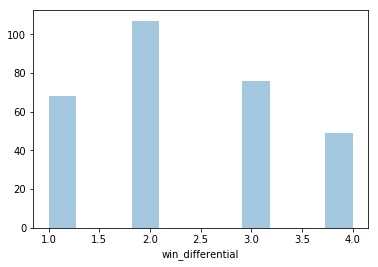

In [17]:
import seaborn as sn
from matplotlib import pyplot as plt

sn.distplot(train_1998_to_2017['win_differential'], kde = False)

plt.show()

#we can see from the histogram below that most series are won by a
#difference of two games

In [18]:
#let's look at what teams have made it to the championship series

finals_1998_to_2017 = train_1998_to_2017[train_1998_to_2017['Round'] == 'Finals']

#we write function that returns the stats of each team in a matchup

def match_up_reg_stats(row):    
    stats_dic_team1 = {}
    stats_dic_team2 = {}

    columns = ['Team','MP','FG','FGA','FG%','3P','3PA','3P%','2P',
           '2PA','2P%','FT','FTA','FT%','ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS']
    columns_wo =['MP','FG','FGA','FG%','3P','3PA','3P%','2P',
               '2PA','2P%','FT','FTA','FT%','ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS']

    for stat in zip(row['2_tensor_vec'][0], columns_wo):
        stats_dic_team1[stat[1]] = [stat[0]]

    for stat in zip(row['2_tensor_vec'][1], columns_wo):
        stats_dic_team2[stat[1]] = [stat[0]]

    stats_df_1 = pd.DataFrame(stats_dic_team1)
    stats_df_1['Team'] = row['Team1']
    
    
    stats_df_1 = stats_df_1[['Team'] + list(stats_df_1.columns)[:-1]]
    
    stats_df_2 = pd.DataFrame(stats_dic_team2)
    
    stats_df_2['Team'] = row['Team2']
    
    
    stats_df_2 = stats_df_2[['Team'] + list(stats_df_2.columns)[:-1]]
    
    concaten = pd.concat([stats_df_1,stats_df_2], ignore_index = True)[columns]
    
    concaten['Year'] = pd.Series([row['Year'], row['Year']])
    concaten['Outcome'] = pd.Series(['Won', 'Lost'])
    return concaten


#for instance if we are interested in the chicago bulls vs utah jazz we pass the first row
#to the function

match_up_reg_stats(finals_1998_to_2017.iloc[0])

#we see that the bulls did slightly better than the jazz during the regular season


,Team,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year,Outcome
0,Chicago Bulls,242.1,37.4,82.9,0.451,3.8,11.7,0.323,33.6,71.2,...,29.7,44.9,23.8,8.5,4.3,14.4,20.6,96.7,1998,Won
1,Utah Jazz,241.2,36.5,74.5,0.490,3.0,8.2,0.372,33.5,66.4,...,29.3,41.1,25.2,7.9,5.0,15.4,23.9,101.0,1998,Lost


In [19]:
#we define a function that takes a row as an argument and returns the difference vector
#reg_stats(team1) - reg_stats(team2)


def math_diff_vec(row):

    
    stats_diff = {}

    stats_diff['Team1'] = row['Team1']
    stats_diff['Team2'] = row['Team2']

    columns_wo =['MP','FG','FGA','FG%','3P','3PA','3P%','2P',
                   '2PA','2P%','FT','FTA','FT%','ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS']
    columns_wo = [ 'd(' + i + ')' for i in columns_wo]

    for stat in zip(row['stats_vec'], columns_wo):
        stats_diff[stat[1]] = [stat[0]]

    stats_diff_df = pd.DataFrame(stats_diff)

    return stats_diff_df[['Team1', 'Team2'] + columns_wo]

bulls_jazz = math_diff_vec(finals_1998_to_2017.iloc[0])

bulls_jazz

,Team1,Team2,d(MP),d(FG),d(FGA),d(FG%),d(3P),d(3PA),d(3P%),d(2P),...,d(FT%),d(ORB),d(DRB),d(TRB),d(AST),d(STL),d(BLK),d(TOV),d(PF),d(PTS)
0,Chicago Bulls,Utah Jazz,0.1,-0.033,4.8,0.8,-0.049,3.5,-1.4,-0.7,...,-6.7,-0.03,-7.7,0.9,3.5,-3.3,-4.3,0.6,-1.0,3.8


In [20]:

columns_wo =['MP','FG','FGA','FG%','3P','3PA','3P%','2P',
                   '2PA','2P%','FT','FTA','FT%','ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS']
diff_columns = [ 'd(' + i + ')' for i in columns_wo]


diff_sign = [1 if bulls_jazz[column].values>0 else 0 for column in diff_columns]


print(diff_sign)

print("positive stat is ", diff_sign.count(1))
print("negative stat is ", diff_sign.count(0))

[1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
positive stat is  11
negative stat is  11


In [21]:
#we generate a dataframe of stats of teams who made it to the championship series from 1998 to 2017
#in order to do some visualization

list_to_concat = []
for index, row in finals_1998_to_2017.iterrows():
    list_to_concat.append(match_up_reg_stats(row))
    
finalist_teams = pd.concat(list_to_concat, ignore_index = True)

finalist_teams


,Team,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year,Outcome
0,Chicago Bulls,242.1,37.4,82.9,0.451,3.8,11.7,0.323,33.6,71.2,...,29.7,44.9,23.8,8.5,4.3,14.4,20.6,96.7,1998,Won
1,Utah Jazz,241.2,36.5,74.5,0.490,3.0,8.2,0.372,33.5,66.4,...,29.3,41.1,25.2,7.9,5.0,15.4,23.9,101.0,1998,Lost
2,San Antonio Spurs,241.5,34.8,76.2,0.456,3.4,10.4,0.330,31.4,65.8,...,31.7,44.0,22.0,8.4,7.0,15.2,20.2,92.8,1999,Won
3,New York Knicks,242.0,32.2,74.1,0.435,4.2,11.8,0.353,28.0,62.3,...,30.2,41.2,19.3,7.9,5.2,16.1,22.8,86.4,1999,Lost
4,Los Angeles Lakers,241.5,38.3,83.4,0.459,4.2,12.8,0.329,34.1,70.6,...,33.4,47.0,23.4,7.5,6.5,13.9,22.5,100.8,2000,Won
5,Indiana Pacers,240.6,37.2,81.0,0.459,7.1,18.1,0.392,30.0,62.8,...,31.9,42.1,22.6,6.8,5.1,14.1,21.8,101.3,2000,Lost
6,Los Angeles Lakers,242.7,37.9,81.5,0.465,5.4,15.5,0.344,32.6,66.0,...,31.5,44.7,23.0,6.9,6.0,14.4,22.8,100.6,2001,Won
7,Philadelphia 76ers,242.1,35.4,79.1,0.447,3.2,9.8,0.326,32.2,69.3,...,31.7,44.8,20.6,8.4,5.0,15.8,20.4,94.7,2001,Lost
8,Los Angeles Lakers,241.2,38.4,83.4,0.461,6.2,17.5,0.354,32.2,65.9,...,31.8,44.3,23.0,7.6,5.8,12.7,22.2,101.3,2002,Won
9,New Jersey Nets,241.8,37.1,83.1,0.446,4.9,14.6,0.338,32.2,68.6,...,30.7,43.3,24.3,8.7,6.0,14.5,21.1,96.2,2002,Lost


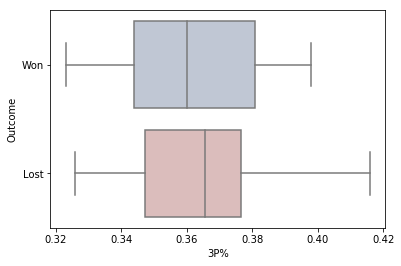

In [22]:
sn.boxplot(y= 'Outcome', x ='3P%' , data = finalist_teams, palette = 'vlag', whis = 'range');

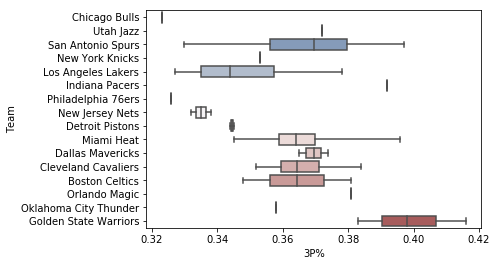

In [23]:
sn.boxplot(y= 'Team', x ='3P%' , data = finalist_teams, palette = 'vlag', whis = 'range');

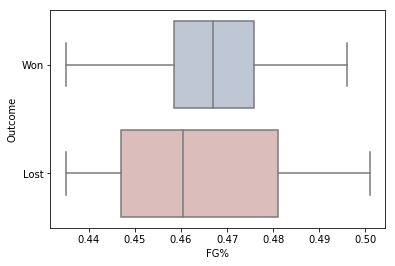

In [24]:
sn.boxplot(y= 'Outcome', x ='FG%' , data = finalist_teams, palette = 'vlag', whis = 'range');

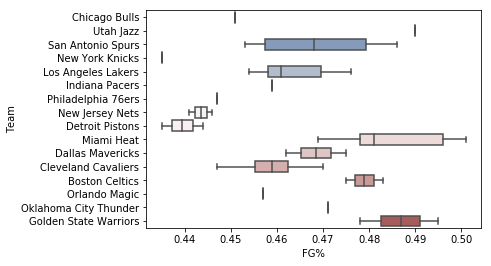

In [25]:
sn.boxplot(y= 'Team', x ='FG%' , data = finalist_teams, palette = 'vlag', whis = 'range');

Now that we have looked at some boxplots for finals series. Let's look at all the playoff series as a whole.

In [27]:
list_to_concat_train = []
for index, row in train_1998_to_2017.iterrows():
    list_to_concat_train.append(match_up_reg_stats(row))
    
team_stats = pd.concat(list_to_concat_train, ignore_index = True)

team_stats

,Team,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year,Outcome
0,Chicago Bulls,242.1,37.4,82.9,0.451,3.8,11.7,0.323,33.6,71.2,...,29.7,44.9,23.8,8.5,4.3,14.4,20.6,96.7,1998,Won
1,Utah Jazz,241.2,36.5,74.5,0.490,3.0,8.2,0.372,33.5,66.4,...,29.3,41.1,25.2,7.9,5.0,15.4,23.9,101.0,1998,Lost
2,Chicago Bulls,242.1,37.4,82.9,0.451,3.8,11.7,0.323,33.6,71.2,...,29.7,44.9,23.8,8.5,4.3,14.4,20.6,96.7,1998,Won
3,Indiana Pacers,241.8,35.6,75.9,0.469,4.9,12.5,0.390,30.7,63.3,...,28.6,39.3,23.0,7.9,4.5,14.2,22.7,96.0,1998,Lost
4,Utah Jazz,241.2,36.5,74.5,0.490,3.0,8.2,0.372,33.5,66.4,...,29.3,41.1,25.2,7.9,5.0,15.4,23.9,101.0,1998,Won
5,Los Angeles Lakers,241.8,38.4,79.7,0.481,6.1,17.3,0.351,32.3,62.5,...,30.1,43.3,24.5,9.0,6.8,15.3,22.7,105.5,1998,Lost
6,Chicago Bulls,242.1,37.4,82.9,0.451,3.8,11.7,0.323,33.6,71.2,...,29.7,44.9,23.8,8.5,4.3,14.4,20.6,96.7,1998,Won
7,Charlotte Hornets,241.2,36.2,77.4,0.468,4.2,11.0,0.383,32.0,66.3,...,28.5,40.6,23.7,8.4,3.8,15.2,21.4,96.6,1998,Lost
8,Indiana Pacers,241.8,35.6,75.9,0.469,4.9,12.5,0.390,30.7,63.3,...,28.6,39.3,23.0,7.9,4.5,14.2,22.7,96.0,1998,Won
9,New York Knicks,241.8,34.9,78.2,0.447,4.7,13.9,0.335,30.3,64.3,...,29.7,41.6,21.8,7.7,3.4,15.2,23.7,91.6,1998,Lost


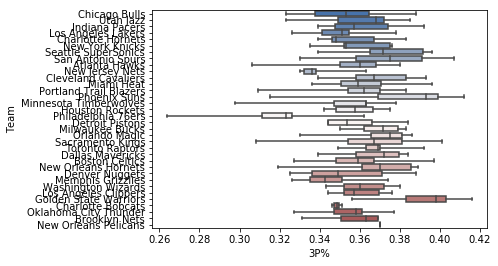

In [28]:
sn.boxplot(y= 'Team', x ='3P%' , data = team_stats, palette = 'vlag', whis = 'range');

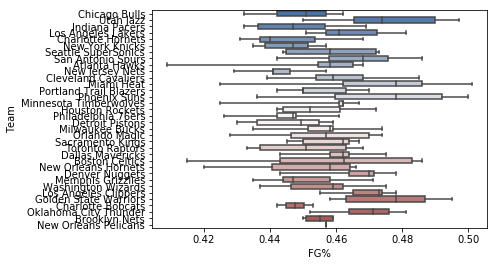

In [29]:
sn.boxplot(y= 'Team', x ='FG%' , data = team_stats, palette = 'vlag', whis = 'range');

## Data Preparation 

In [30]:
#here we also need to include the negative win differentials web obtain
#if we reverse the order of winner and loser teams. 
#all the entries of stats_vec column will be negated while
#the order of the rows in the entries of 2_tensor_vec will switch.


train_1998_to_2017_neg = train_1998_to_2017.copy()

train_1998_to_2017_neg['stats_vec'] = train_1998_to_2017_neg['stats_vec'].apply(lambda x:
                                                         np.array([-1*i for i in x]))


#for the 2_tensor_vec column we want to use the normalized stats
train_1998_to_2017_norm_neg = train_1998_to_2017_norm.copy()

train_1998_to_2017_neg['2_tensor_vec'] = train_1998_to_2017_norm_neg['2_tensor_vec'].apply(lambda x:
                                                               [x[1],x[0]])

#we switch to team1 and team2.

train_1998_to_2017_neg['win_differential'] = train_1998_to_2017_neg['win_differential'].apply(lambda x:
                                                                       -1*x)
train_1998_to_2017_neg["Team1"] = train_1998_to_2017["Team2"]

train_1998_to_2017_neg["Team2"] = train_1998_to_2017['Team1']

train_1998_to_2017_neg["Year"] = train_1998_to_2017["Year"]

train_1998_to_2017_neg["Round"] = train_1998_to_2017["Round"]

train_1998_to_2017_neg = train_1998_to_2017_neg[["Year", "Round","Team1", "Team2", 'stats_vec', '2_tensor_vec',
                          'win_differential']]



In [31]:
train_1998_to_2017_neg

,Year,Round,Team1,Team2,stats_vec,2_tensor_vec,win_differential
0,1998,Finals,Utah Jazz,Chicago Bulls,"[-0.10000000000000142, 0.03300000000000003, -4...","[[-1.0267040449856084, 0.13651480919037165, -1...",-2
1,1998,Eastern Conference Finals,Indiana Pacers,Chicago Bulls,"[-2.900000000000002, 0.014000000000000012, -7....","[[-0.12245094114508356, -0.5413518295480032, -...",-1
2,1998,Western Conference Finals,Los Angeles Lakers,Utah Jazz,"[-1.2000000000000028, 0.013000000000000012, -3...","[[-0.12245094114508356, 1.5675666020824977, 0....",-4
3,1998,Eastern Conference Semifinals,Charlotte Hornets,Chicago Bulls,"[-1.6000000000000014, 0.01100000000000001, -4....","[[-1.0267040449856084, -0.0894407370557515, -0...",-3
4,1998,Eastern Conference Semifinals,New York Knicks,Indiana Pacers,"[-0.3999999999999986, -0.014000000000000012, 1...","[[-0.12245094114508356, -1.068581437455631, -0...",-3
5,1998,Western Conference Semifinals,Seattle SuperSonics,Los Angeles Lakers,"[-2.6999999999999957, -0.020000000000000018, -...","[[-1.478830596905828, 0.6637444170979995, 0.00...",-3
6,1998,Western Conference Semifinals,San Antonio Spurs,Utah Jazz,"[-1.8000000000000007, -0.016000000000000014, -...","[[-0.12245094114508356, -0.7673073757941318, -...",-3
7,1998,Eastern Conference First Round,Atlanta Hawks,Charlotte Hornets,"[-0.8999999999999986, -0.0040000000000000036, ...","[[0.7818021626953985, -0.8426258912095026, -0....",-2
8,1998,Eastern Conference First Round,New Jersey Nets,Chicago Bulls,"[-0.10000000000000142, -0.012999999999999956, ...","[[0.7818021626953985, 0.7390629325133703, 1.96...",-3
9,1998,Eastern Conference First Round,Cleveland Cavaliers,Indiana Pacers,"[-0.0, -0.01899999999999996, 2.600000000000008...","[[-0.12245094114508356, -1.4451740145325065, -...",-2


Now that we have training data for seasons from 1998 through 2017 inclusive. We are ready to generate the test data, which will be 2018 and 2019 (it's going on as we speak!!)


In [32]:
def gen_test_reg_season(year):
    
    url = 'https://www.basketball-reference.com/leagues/NBA_' + year + '.html'
    temp_browser = webdriver.Chrome('chromedriver')
    temp_browser.get(url)
    temp_string = '//*[@id="all_team-stats-per_game"]/div[3]'
    
    temp_table = temp_browser.find_element_by_xpath(temp_string)
    
    teamNames = []
    columns = []
    listOfVal = []
    listOfCol = []
    dictionary = {}

    for index, line in enumerate(temp_table.text.split('\n')):
        if index == 0:
            columns = line.split(" ")
            columns = [name for name in columns if name != 'Team']
        else:
            current = line.split(" ")
            
            #concatenate to retrieve team names
            temp_name = [entry for entry in current if not is_numeric(entry)]

            teamNames.append(" ".join(temp_name))
            current = [float(entry) for entry in current if is_numeric(entry)]

            listOfVal.append(current)

    #rearrange listOfVal so that we have column values as lists

    #delete league average row
    del listOfVal[-1]
    del teamNames[-1]
    

    #need to extract names from result table
    if "Charlotte Hornets" in teamNames and year == "2014":
        key = teamNames.index("Charlotte Hornets")
        teamNames[key] = "Charlotte Bobcats"
   
    for i in range(len(listOfVal[0])):
        listOfCol.append([lis[i] for lis in listOfVal])

    #add values to dictionary from listOfCol
    for i in range(len(columns)):
        dictionary[columns[i]] = listOfCol[i]
    

    #determine result for teams
    final_result = pd.DataFrame(dictionary)
    
    #let's drop the number of games
    final_result = final_result.drop(['G'], axis = 1)
    
    #add team name
    final_result['Team'] = teamNames
    
    #let's just include teams that made it to the playoffs
    final_result = final_result[final_result['Team'].str.endswith('*')]
    
    #now remove the asterisk at the end
    final_result['Team'] = final_result['Team'].apply(lambda x: x[:-1])
    final_result.reset_index(drop = True, inplace = True)
    
    
    columns = list(final_result.columns)

    #rearrange columns so that team comes first

    newcolumns = [columns[-1]] + columns[:-1]
    newcolumns = ['Team','MP','FG','FGA','FG%','3P','3PA','3P%','2P','2PA','2P%',
                 'FT','FTA','FT%','ORB','DRB','TRB','AST','STL','BLK','TOV',
                 'PF','PTS']
    
    #final_result = final_result[newcolumns]
    
    
    
    
    final_result = final_result[newcolumns]   
    
    
    

    return final_result
    



In [33]:
def gen_test_reg_season_norm(year):
    
    url = 'https://www.basketball-reference.com/leagues/NBA_' + year + '.html'
    temp_browser = webdriver.Chrome('chromedriver')
    temp_browser.get(url)
    temp_string = '//*[@id="all_team-stats-per_game"]/div[3]'
    
    temp_table = temp_browser.find_element_by_xpath(temp_string)
    
    teamNames = []
    columns = []
    listOfVal = []
    listOfCol = []
    dictionary = {}

    for index, line in enumerate(temp_table.text.split('\n')):
        if index == 0:
            columns = line.split(" ")
            columns = [name for name in columns if name != 'Team']
        else:
            current = line.split(" ")
            
            #concatenate to retrieve team names
            temp_name = [entry for entry in current if not is_numeric(entry)]

            teamNames.append(" ".join(temp_name))
            current = [float(entry) for entry in current if is_numeric(entry)]

            listOfVal.append(current)

    #rearrange listOfVal so that we have column values as lists

    #delete league average row
    del listOfVal[-1]
    del teamNames[-1]
    

    #need to extract names from result table
    if "Charlotte Hornets" in teamNames and year == "2014":
        key = teamNames.index("Charlotte Hornets")
        teamNames[key] = "Charlotte Bobcats"
   
    for i in range(len(listOfVal[0])):
        listOfCol.append([lis[i] for lis in listOfVal])

    #add values to dictionary from listOfCol
    for i in range(len(columns)):
        dictionary[columns[i]] = listOfCol[i]
    

    #determine result for teams
    final_result = pd.DataFrame(dictionary)
    
    #let's drop the number of games
    final_result = final_result.drop(['G'], axis = 1)
    
    #add team name
    final_result['Team'] = teamNames
    
    #let's just include teams that made it to the playoffs
    final_result = final_result[final_result['Team'].str.endswith('*')]
    
    #now remove the asterisk at the end
    final_result['Team'] = final_result['Team'].apply(lambda x: x[:-1])
    final_result.reset_index(drop = True, inplace = True)
    
    
    columns = list(final_result.columns)

    #rearrange columns so that team comes first

    newcolumns = [columns[-1]] + columns[:-1]
    newcolumns = ['Team','MP','FG','FGA','FG%','3P','3PA','3P%','2P','2PA','2P%',
                 'FT','FTA','FT%','ORB','DRB','TRB','AST','STL','BLK','TOV',
                 'PF','PTS']
    
    #final_result = final_result[newcolumns]
    
    final_result
    
    numeric_col = ['MP','FG','FGA','FG%','3P','3PA','3P%','2P','2PA','2P%',
                 'FT','FTA','FT%','ORB','DRB','TRB','AST','STL','BLK','TOV',
                 'PF','PTS']
    
    final_result = final_result[newcolumns]   
    
    to_normalize = final_result[numeric_col]
    
    std_scale = preprocessing.StandardScaler().fit(to_normalize)
    
    normalized = std_scale.transform(to_normalize)
    
    normalized_col = pd.DataFrame(normalized, index = to_normalize.index,
                                 columns = to_normalize.columns)
    
    final_result.update(normalized_col)
    

    return final_result
    



In [34]:
#for prediction

reg_season_2018 = gen_test_reg_season('2018')
reg_season_2018



,Team,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Golden State Warriors,240.6,42.8,85.1,0.503,11.3,28.9,0.391,31.5,56.2,...,0.815,8.4,35.1,43.5,29.3,8.0,7.5,15.5,19.6,113.5
1,Houston Rockets,240.9,38.7,84.2,0.460,15.3,42.3,0.362,23.4,41.9,...,0.781,9.0,34.5,43.5,21.5,8.5,4.8,13.8,19.5,112.4
2,New Orleans Pelicans,243.4,42.7,88.3,0.483,10.2,28.2,0.362,32.5,60.1,...,0.772,8.7,35.7,44.3,26.8,8.0,5.9,14.9,19.1,111.7
3,Toronto Raptors,241.8,41.3,87.4,0.472,11.8,33.0,0.358,29.5,54.4,...,0.794,9.8,34.2,44.0,24.3,7.6,6.1,13.4,21.7,111.7
4,Cleveland Cavaliers,240.6,40.4,84.8,0.476,12.0,32.1,0.372,28.4,52.6,...,0.779,8.5,33.7,42.1,23.4,7.1,3.8,13.7,18.6,110.9
5,Philadelphia 76ers,241.2,40.8,86.6,0.472,11.0,29.8,0.369,29.9,56.7,...,0.752,10.9,36.5,47.4,27.1,8.3,5.1,16.5,22.1,109.8
6,Minnesota Timberwolves,241.5,41.0,86.1,0.476,8.0,22.5,0.357,33.0,63.6,...,0.804,10.3,31.6,42.0,22.7,8.4,4.2,12.5,18.2,109.5
7,Oklahoma City Thunder,241.8,39.9,88.1,0.453,10.7,30.4,0.354,29.1,57.7,...,0.716,12.5,32.6,45.1,21.3,9.1,5.0,14.0,20.2,107.9
8,Washington Wizards,242.1,39.9,85.6,0.467,9.9,26.5,0.375,30.0,59.1,...,0.772,10.0,33.1,43.1,25.2,7.9,4.3,14.6,21.3,106.6
9,Milwaukee Bucks,241.8,39.7,83.0,0.478,8.8,24.7,0.355,31.0,58.3,...,0.783,8.4,31.5,39.8,23.2,8.8,5.4,13.8,21.4,106.5


In [35]:
#for prediction

reg_season_2018_norm = gen_test_reg_season_norm('2018')
reg_season_2018_norm


,Team,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Golden State Warriors,-1.075775,1.980840,-0.394795,2.589929,0.399412,-0.045939,2.612013,0.860918,-0.078177,...,1.722634,-1.195229,0.805353,-0.079679,2.400804,-0.082339,2.706624,1.465615,-0.145755,1.648009
1,Houston Rockets,-0.704285,-1.034081,-0.980883,-0.591984,2.788420,2.938712,-0.336829,-2.614937,-3.010453,...,0.201347,-0.621519,0.368551,-0.079679,-0.859483,0.741048,-0.362304,-0.322041,-0.223491,1.326090
2,New Orleans Pelicans,2.391472,1.907305,1.689073,1.109970,-0.257565,-0.201854,-0.336829,1.290036,0.721535,...,-0.201347,-0.908374,1.242154,0.405982,1.355840,-0.082339,0.888000,0.834678,-0.534434,1.121232
3,Toronto Raptors,0.410188,0.877820,1.102985,0.295992,0.698038,0.867275,-0.743566,0.002682,-0.447275,...,0.783015,0.143427,0.150151,0.223859,0.310877,-0.741048,1.115328,-0.742666,1.486699,1.121232
4,Cleveland Cavaliers,-1.075775,0.216008,-0.590158,0.591984,0.817489,0.666813,0.680013,-0.469348,-0.816372,...,0.111859,-1.099610,-0.213851,-0.929585,-0.065310,-1.564435,-1.498944,-0.427197,-0.923114,0.887108
5,Philadelphia 76ers,-0.332794,0.510147,0.582018,0.295992,0.220237,0.154523,0.374960,0.174329,0.024350,...,-1.096222,1.195229,1.824557,2.287918,1.481236,0.411693,-0.021312,2.517178,1.797642,0.565189
6,Minnesota Timberwolves,0.038697,0.657216,0.256413,0.591984,-1.571519,-1.471444,-0.845250,1.504595,1.439224,...,1.230453,0.621519,-1.742656,-0.990293,-0.357900,0.576371,-1.044288,-1.689072,-1.234057,0.477392
7,Oklahoma City Thunder,0.410188,-0.151665,1.558831,-1.109970,0.041061,0.288164,-1.150302,-0.168965,0.229404,...,-2.706996,2.725121,-1.014654,0.891643,-0.943080,1.729113,-0.134976,-0.111729,0.320660,0.009145
8,Washington Wizards,0.781678,-0.151665,-0.069191,-0.073998,-0.436740,-0.580504,0.985066,0.217241,0.516480,...,-0.201347,0.334664,-0.650652,-0.322509,0.687064,-0.247016,-0.930624,0.519209,1.175755,-0.371305
9,Milwaukee Bucks,0.410188,-0.298735,-1.762334,0.739980,-1.093718,-0.981427,-1.048618,0.646359,0.352437,...,0.290834,-1.195229,-1.815456,-2.325861,-0.148907,1.235080,0.319680,-0.322041,1.253491,-0.400571


In [36]:
reg_season_2019 = gen_test_reg_season('2019')
reg_season_2019

,Team,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Milwaukee Bucks,241.2,43.4,91.1,0.476,13.5,38.2,0.353,29.9,52.9,...,0.773,9.3,40.4,49.7,26.0,7.5,5.9,13.9,19.6,118.1
1,Golden State Warriors,241.5,44.0,89.8,0.491,13.3,34.4,0.385,30.8,55.3,...,0.801,9.7,36.5,46.2,29.4,7.6,6.4,14.3,21.4,117.7
2,Philadelphia 76ers,241.5,41.5,88.2,0.471,10.8,30.2,0.359,30.7,58.0,...,0.771,10.9,36.9,47.8,26.9,7.4,5.3,14.9,21.3,115.2
3,Los Angeles Clippers,241.8,41.3,87.5,0.471,10.0,25.8,0.388,31.3,61.7,...,0.792,9.7,35.8,45.5,24.0,6.8,4.7,14.5,23.3,115.1
4,Portland Trail Blazers,242.1,42.3,90.6,0.467,11.0,30.7,0.359,31.3,59.8,...,0.814,11.8,36.2,48.0,23.0,6.7,5.0,13.8,20.4,114.7
5,Oklahoma City Thunder,242.1,42.6,94.0,0.454,11.4,32.6,0.348,31.3,61.3,...,0.713,12.6,35.5,48.1,23.4,9.3,5.2,14.0,22.4,114.5
6,Toronto Raptors,242.4,42.2,89.1,0.474,12.4,33.8,0.366,29.8,55.3,...,0.804,9.6,35.6,45.2,25.4,8.3,5.3,14.0,21.0,114.4
7,Houston Rockets,241.8,39.2,87.4,0.449,16.1,45.4,0.356,23.1,42.0,...,0.791,10.2,31.9,42.1,21.2,8.5,4.9,13.3,22.0,113.9
8,Boston Celtics,241.2,42.1,90.5,0.465,12.6,34.5,0.365,29.5,56.0,...,0.802,9.8,34.7,44.5,26.3,8.6,5.3,12.8,20.4,112.4
9,Brooklyn Nets,243.7,40.3,89.7,0.449,12.8,36.2,0.353,27.5,53.6,...,0.745,11.0,35.6,46.6,23.8,6.6,4.1,15.1,21.5,112.2


In [37]:
reg_season_2019_norm = gen_test_reg_season_norm('2019')
reg_season_2019_norm

,Team,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Milwaukee Bucks,-0.541610,1.390347,1.049064,0.822423,1.025629,1.100781,-0.727985,0.112563,-0.699042,...,-0.060639,-1.071578,2.769291,2.018431,0.460584,-0.097458,1.295088,0.039500,-0.872221,1.640951
1,Golden State Warriors,-0.153591,1.829404,0.333637,1.997314,0.899882,0.326157,1.587098,0.507906,-0.217981,...,0.876134,-0.681913,0.559524,0.153214,2.165059,0.013923,2.092065,0.545101,0.449882,1.517397
2,Philadelphia 76ers,-0.153591,0.000000,-0.546889,0.430793,-0.671964,-0.530006,-0.293907,0.463979,0.323213,...,-0.127552,0.487081,0.786167,1.005885,0.911769,-0.208838,0.338715,1.303503,0.376432,0.745185
3,Los Angeles Clippers,0.234428,-0.146352,-0.932119,0.430793,-1.174955,-1.426938,1.804137,0.727542,1.064849,...,0.575028,-0.681913,0.162899,-0.219829,-0.542048,-0.877118,-0.617657,0.797902,1.845435,0.714296
4,Portland Trail Blazers,0.622447,0.585409,0.773900,0.117489,-0.546216,-0.428081,-0.293907,0.727542,0.684009,...,1.311064,1.363827,0.389542,1.112468,-1.043364,-0.988498,-0.139471,-0.086900,-0.284619,0.590742
5,Oklahoma City Thunder,0.622447,0.804938,2.645018,-0.900750,-0.294721,-0.040770,-1.089717,0.727542,0.984672,...,-2.068011,2.143157,-0.007083,1.165760,-0.842838,1.907383,0.179320,0.165900,1.184384,0.528965
6,Toronto Raptors,1.010466,0.512233,-0.051593,0.665771,0.334017,0.203848,0.212517,0.068636,-0.217981,...,0.976502,-0.779330,0.049578,-0.379705,0.159795,0.793583,0.338715,0.165900,0.156082,0.498077
7,Houston Rockets,0.234428,-1.683052,-0.987152,-1.292380,2.660349,2.568488,-0.510946,-2.874476,-2.883861,...,0.541572,-0.194832,-2.046867,-2.031754,-1.945734,1.016343,-0.298866,-0.718902,0.890583,0.343634
8,Boston Celtics,-0.541610,0.439057,0.718867,-0.039163,0.459765,0.346542,0.140171,-0.063145,-0.077671,...,0.909590,-0.584497,-0.460368,-0.752748,0.610979,1.127723,0.338715,-1.350903,-0.284619,-0.119693
9,Brooklyn Nets,2.691882,-0.878114,0.278604,-1.292380,0.585513,0.693084,-0.727985,-0.941686,-0.558732,...,-0.997413,0.584497,0.049578,0.366382,-0.642311,-1.099878,-1.574030,1.556304,0.523332,-0.181470


In [38]:
#write another helper function to generate first round series matchups
#this method is intender for the 2018 and 2019 playoffs predictions

def first_round_matchups(year):
    
    url = 'https://www.basketball-reference.com/leagues/NBA_' + year + '.html'
    
    temp_browser = webdriver.Chrome('chromedriver')
    
    temp_browser.get(url)
    
    result_string = '//*[@id="all_all_playoffs"]/div[3]'
    result_table = temp_browser.find_element_by_xpath(result_string)
    playoff_results = result_table.text.split('\n')
    #teamNames = list(reg_team_pg_stats(year)['Team'])
    
    team1_list = []
    team2_list = []
    score_list = []
    round_list = []
     
    for idx, row in enumerate(playoff_results):
        line = playoff_results[idx].split(" ")
        
        start1 = 0
        end1 = 0
        
        start2 = 0
        end2 = 0
        
        team1 = ''
        team2 = ''
        score = ''
        rnd = ''
        
        #find the start index
        if 'Round' in line:
            start1 = line.index('Round')
            
        if 'over' in line:
            end1 = line.index('over')
            start2 = end1
        
        ser = pd.Series(line)
        
        bool_ser = ser.str.contains('(', regex = False)
        
        end2 = bool_ser[bool_ser == True].index[0]
        
        team1 = " ".join(line[start1 + 1: end1])
        team2 = " ".join(line[start2 + 1 : end2 - 1])
        rnd = " ".join(line[: start1+1])
        
        
        score = line[end2]
     
        team1_list.append(team1)
        team2_list.append(team2)
        score_list.append(score)
        round_list.append(rnd)
        
    result = pd.DataFrame({'Team1': team1_list, 'Team2': team2_list, 
                         'Score' : score_list, 'Round' : round_list})
    result = result[['Round','Team1', 'Team2', 'Score']].iloc[-8:,]
    
    return result
    

In [39]:
#for prediction

first_round_2018 = first_round_matchups('2018')
first_round_2018

,Round,Team1,Team2,Score
7,Eastern Conference First Round,Boston Celtics,Milwaukee Bucks,(4-3)
8,Eastern Conference First Round,Cleveland Cavaliers,Indiana Pacers,(4-3)
9,Eastern Conference First Round,Philadelphia 76ers,Miami Heat,(4-1)
10,Eastern Conference First Round,Toronto Raptors,Washington Wizards,(4-2)
11,Western Conference First Round,Golden State Warriors,San Antonio Spurs,(4-1)
12,Western Conference First Round,Houston Rockets,Minnesota Timberwolves,(4-1)
13,Western Conference First Round,New Orleans Pelicans,Portland Trail Blazers,(4-0)
14,Western Conference First Round,Utah Jazz,Oklahoma City Thunder,(4-2)


In [40]:
#for prediction

first_round_2019 = first_round_matchups('2019')
first_round_2019

,Round,Team1,Team2,Score
6,Eastern Conference First Round,Boston Celtics,Indiana Pacers,(4-0)
7,Eastern Conference First Round,Milwaukee Bucks,Detroit Pistons,(4-0)
8,Eastern Conference First Round,Philadelphia 76ers,Brooklyn Nets,(4-1)
9,Eastern Conference First Round,Toronto Raptors,Orlando Magic,(4-1)
10,Western Conference First Round,Denver Nuggets,San Antonio Spurs,(4-3)
11,Western Conference First Round,Golden State Warriors,Los Angeles Clippers,(4-2)
12,Western Conference First Round,Houston Rockets,Utah Jazz,(4-1)
13,Western Conference First Round,Portland Trail Blazers,Oklahoma City Thunder,(4-1)


In [41]:
def gen_test_data_round1(results, reg_stats):
    #we initiate the dic where we will store our columns
    dic ={}
    
    #let's create the 1-tensor or stats_vec
    list_of_vec = []
    zip_ob =  zip(list(results['Team1']),list(results['Team2']))

    for tup in zip_ob:
        list_of_vec.append(stats_vec(*tup, reg_stats))

    dic['stats_vec'] = list_of_vec
    
    
    #also, the 2-tensor
    #let's add 2-tensor as a column to test it on a model
    zip_ob1 =  zip(list(results['Team1']),list(results['Team2']))
    list_of_vec1 = []
    for tup in zip_ob1:
        list_of_vec1.append(two_tensor(*tup, reg_stats))

    dic['2_tensor_vec'] = list_of_vec1
    
    #finally, the winner and loser columns
    dic['Team1'] = results['Team1']
    dic['Team2'] = results['Team2']
    dic['Round'] = results['Round']
    dic['win_differential'] = results['Score'].apply(lambda x: int(x[1]) - int(x[3]))
    final_df = pd.DataFrame(dic)
    final_df = final_df[['Round','Team1','Team2','stats_vec','2_tensor_vec','win_differential']]

    return final_df
    
    

In [42]:
#we generate test_data

test_data_2018 = gen_test_data_round1(first_round_2018, reg_season_2018)
test_data_2018


,Round,Team1,Team2,stats_vec,2_tensor_vec,win_differential
7,Eastern Conference First Round,Boston Celtics,Milwaukee Bucks,"[-4.100000000000001, -0.040000000000000036, -3...","[[241.5, 38.3, 85.1, 0.45, 11.5, 30.4, 0.377, ...",1
8,Eastern Conference First Round,Cleveland Cavaliers,Indiana Pacers,"[-3.400000000000002, 0.027000000000000024, -9....","[[240.6, 40.4, 84.8, 0.476, 12.0, 32.1, 0.372,...",1
9,Eastern Conference First Round,Philadelphia 76ers,Miami Heat,"[2.099999999999998, 0.018000000000000016, 1.90...","[[241.2, 40.8, 86.6, 0.472, 11.0, 29.8, 0.369,...",3
10,Eastern Conference First Round,Toronto Raptors,Washington Wizards,"[-0.5, 0.03300000000000003, -4.700000000000003...","[[241.8, 41.3, 87.4, 0.472, 11.8, 33.0, 0.358,...",2
11,Western Conference First Round,Golden State Warriors,San Antonio Spurs,"[0.8999999999999986, 0.061000000000000054, -5....","[[240.6, 42.8, 85.1, 0.503, 11.3, 28.9, 0.391,...",3
12,Western Conference First Round,Houston Rockets,Minnesota Timberwolves,"[-9.600000000000001, 0.039000000000000035, -21...","[[240.9, 38.7, 84.2, 0.46, 15.3, 42.3, 0.362, ...",3
13,Western Conference First Round,New Orleans Pelicans,Portland Trail Blazers,"[3.5, 0.04700000000000004, 1.3000000000000043,...","[[243.4, 42.7, 88.3, 0.483, 10.2, 28.2, 0.362,...",4
14,Western Conference First Round,Utah Jazz,Oklahoma City Thunder,"[-1.6000000000000014, 0.010000000000000009, -4...","[[240.9, 38.3, 82.9, 0.462, 10.8, 29.6, 0.366,...",2


In [43]:
test_data_2019 = gen_test_data_round1(first_round_2019,reg_season_2019)

#because of the preliminary format of playoff result tables on
#the website we are scraping we need to change the order of some rows
#in our test data for the 2019 playoffs


def switch_rows(rowA, rowB, dataframe):
    temp = dataframe.iloc[rowA].copy()
    dataframe.iloc[rowA] = dataframe.iloc[rowB]
    dataframe.iloc[rowB] = temp

#switch rows eight and nine
switch_rows(4,5,test_data_2019)

#switch rows one and two
switch_rows(1,2,test_data_2019)

test_data_2019

test_data_2019.to_csv("test_data_2019.csv")

In [44]:
#for method 1 (Multilayer Perceptron) we extract the stats_vec column
#to train our model

train_1998_to_2017_with_neg = pd.concat([train_1998_to_2017, train_1998_to_2017_neg], ignore_index = True)

#we train our multilayer perceptron on the array of 1-tensors below.

stats_vec_with_neg = train_1998_to_2017_with_neg['stats_vec'].apply(lambda x: x.tolist())

stats_vec_with_neg = np.array(list(stats_vec_with_neg), dtype = np.float)



## Method 1 

In [45]:
#let's fit our data to a MLP Classifier using scikit learn

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


clf = MLPClassifier(hidden_layer_sizes = (4,4), 
                    max_iter = 500, alpha = 0.01, solver = 'sgd', random_state = 42)

x = stats_vec_with_neg
y = train_1998_to_2017_with_neg['win_differential']

clf.fit(x,y)



MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(4, 4), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [46]:
#now that we have fit our model let's predict the first round series
#for 2018 and 2019


#2018 first round
vec = test_data_2018['stats_vec']
vec = np.array(list(vec), dtype = np.float)

#we want to test negative predictions
vec_neg = test_data_2018['stats_vec'].apply(lambda x:[-1 * i for i in x])
vec_neg = np.array(list(vec_neg), dtype = np.float)

#predict
print('2018 1st round predictions')
y_pred = clf.predict(vec)
print('positive win_differential', y_pred)
#we want to see if we get the negative of the vector y_pred here
y_pred_neg = clf.predict(vec_neg)
print('negative win_differential', y_pred_neg)



#2019 first round
vec_2019 = test_data_2019.stats_vec
vec_2019 = np.array(list(vec_2019), dtype = np.float)

vec_2019_neg = test_data_2019.stats_vec.apply(lambda x: [-1 * i for i in x])
vec_2019_neg = np.array(list(vec_2019_neg), dtype = np.float)

print()
print('2019 1st round predictions')
y_pred_2019 = clf.predict(vec_2019)
print('positive win_differential', y_pred_2019)
y_pred_2019_neg = clf.predict(vec_2019_neg)
print('negative win_differential', y_pred_2019_neg)



2018 1st round predictions
positive win_differential [2 2 2 2 2 2 2 2]
negative win_differential [ 2 -2 -3 -2 -4 -2 -4 -2]

2019 1st round predictions
positive win_differential [ 2  2  2  2  2  2 -2  2]
negative win_differential [-2 -2 -3 -3 -3  2  2  2]


In [47]:
def predict_results(model, test_data, predictor, reg_season_test):
    
    #here predictor can be stats_vec or 2_tensor
    #because of time restrictions we will look at stats_vec first
    
    vec = test_data[predictor]
    vec = np.array(list(vec), dtype = np.float)
    
    round1_pred = model.predict(vec)
    
    
    result_dic = {}
    result_dic['Team1'] = test_data['Team1']
    result_dic['Team2'] = test_data['Team2']
    result_dic['pred_win_differential'] = round1_pred
    result_dic['actual_win_differential'] = test_data['win_differential']
    result_dic['Round'] = test_data['Round']

    round1_df = pd.DataFrame(result_dic).reset_index().drop(['index'], axis = 1)
    
    round1_df = round1_df[['Round','Team1','Team2','pred_win_differential']]
    
    #now let's generate results for the conference semifinals
    semifinalists = round1_df.apply(lambda x: x['Team1'] if x['pred_win_differential']>0 else x['Team2'], axis =1)
    
    team1 = []
    team2 = []

    for index, val in enumerate(semifinalists):
        
        
        if index < 2 :
            team1.append(val)
        elif index <4:
            team2.append(val)
        elif index < 6:
            team1.append(val)
        else: team2.append(val)
            
        

    semifinal_dic = {}

    semifinal_dic['Team1'] = team1
    semifinal_dic['Team2'] = team2

    semifinal_dic['Round'] = ['Eastern Conference Semifinals']*2 + ['Western Conference Semifinals']*2


    semifinal_dic['stats_vec'] = [stats_vec(*tup, reg_season_test) for tup in zip(team1,team2)]

    vec_semi = np.array(semifinal_dic['stats_vec'], dtype = np.float)



    semifinal_pred = model.predict(vec_semi)

    semifinal_dic['pred_win_differential'] = semifinal_pred

    semifinal_df = pd.DataFrame(semifinal_dic)
    
    semifinal_df = semifinal_df[['Round','Team1','Team2','pred_win_differential']]
    
    #conference finals
    
    conf_finalists = semifinal_df.apply(lambda x: x['Team1'] if x['pred_win_differential']>0 else x['Team2'], axis =1)    
    
    team1_conf = []
    team2_conf = []

    for index, val in enumerate(conf_finalists):
        if index%2 == 0 :
            team1_conf.append(val)
        else:
            team2_conf.append(val)
        
    conf_final_dic = {}

    conf_final_dic['Team1'] = team1_conf
    conf_final_dic['Team2'] = team2_conf

    conf_final_dic['Round'] = ['Eastern Conference Finals'] + ['Western Conference Finals']


    conf_final_dic['stats_vec'] = [stats_vec(*tup, reg_season_test) for tup in zip(team1_conf,team2_conf)]



    vec_conffinal = np.array(conf_final_dic['stats_vec'], dtype = np.float)

    conffinal_pred = model.predict(vec_conffinal)

    conf_final_dic['pred_win_differential'] = conffinal_pred

    conf_final_df = pd.DataFrame(conf_final_dic)
    
    conf_final_df = conf_final_df[['Round','Team1','Team2','pred_win_differential']]
    
    #finally, the final! lol!
    
    finalists = conf_final_df.apply(lambda x: x['Team1'] if x['pred_win_differential']>0 else x['Team2'], axis =1)  
    
    team1_final = []
    team2_final = []
    
    for index, val in enumerate(finalists):
        if index%2 == 0 :
            team1_final.append(val)
        else: team2_final.append(val)
    
    final_dic = {}

    final_dic['Team1'] = team1_final
    final_dic['Team2'] = team2_final

    final_dic['Round'] = ['Final']


    final_dic['stats_vec'] = [stats_vec(*tup, reg_season_test) for tup in zip(team1_final,team2_final)]



    vec_final = np.array(final_dic['stats_vec'], dtype = np.float)

    final_pred = model.predict(vec_final)

    final_dic['pred_win_differential'] = final_pred

    final_df = pd.DataFrame(final_dic)
    
    final_df = final_df[['Round','Team1','Team2','pred_win_differential']]
            
    return pd.concat([final_df, conf_final_df, semifinal_df, round1_df]).reset_index().drop(['index'], axis = 1)


In [48]:
#2018 win_differential predictions

pred_2018 = predict_results(clf, test_data_2018, 'stats_vec', reg_season_2018)

pred_2018['Score'] = pred_2018.pred_win_differential.apply(lambda x: 
                                                            '4' + '-' + str(x) if x>0 else str(-1*x) + '-' + str(4) )

pred_2018['winning_team'] = pred_2018.apply(lambda x: x['Team1'] if x['pred_win_differential'] > 0 else x['Team2'], axis = 1)


pred_2018

,Round,Team1,Team2,pred_win_differential,Score,winning_team
0,Final,Philadelphia 76ers,Golden State Warriors,-2,2-4,Golden State Warriors
1,Eastern Conference Finals,Philadelphia 76ers,Toronto Raptors,2,4-2,Philadelphia 76ers
2,Western Conference Finals,Golden State Warriors,Houston Rockets,2,4-2,Golden State Warriors
3,Eastern Conference Semifinals,Boston Celtics,Philadelphia 76ers,-3,3-4,Philadelphia 76ers
4,Eastern Conference Semifinals,Cleveland Cavaliers,Toronto Raptors,-2,2-4,Toronto Raptors
5,Western Conference Semifinals,Golden State Warriors,New Orleans Pelicans,2,4-2,Golden State Warriors
6,Western Conference Semifinals,Houston Rockets,Utah Jazz,2,4-2,Houston Rockets
7,Eastern Conference First Round,Boston Celtics,Milwaukee Bucks,2,4-2,Boston Celtics
8,Eastern Conference First Round,Cleveland Cavaliers,Indiana Pacers,2,4-2,Cleveland Cavaliers
9,Eastern Conference First Round,Philadelphia 76ers,Miami Heat,2,4-2,Philadelphia 76ers


In [49]:
#2019 win_differential predictions

test_pred_2019 = predict_results(clf, test_data_2019, 'stats_vec', reg_season_2019)

test_pred_2019['Score'] = test_pred_2019.pred_win_differential.apply(lambda x: 
                                                            '4' + '-' + str(x) if x>0 else str(4+x) + '-' + str(4) )
test_pred_2019['winning_team'] = test_pred_2019.apply(lambda x: x['Team1'] if x['pred_win_differential'] > 0 else x['Team2'], axis = 1)

test_pred_2019


#my multilayer perceptron classifier predicts Milwaukee Bucks will
#the champions this year!

,Round,Team1,Team2,pred_win_differential,Score,winning_team
0,Final,Milwaukee Bucks,Golden State Warriors,2,4-2,Milwaukee Bucks
1,Eastern Conference Finals,Milwaukee Bucks,Toronto Raptors,2,4-2,Milwaukee Bucks
2,Western Conference Finals,Golden State Warriors,Portland Trail Blazers,2,4-2,Golden State Warriors
3,Eastern Conference Semifinals,Boston Celtics,Milwaukee Bucks,-4,0-4,Milwaukee Bucks
4,Eastern Conference Semifinals,Philadelphia 76ers,Toronto Raptors,-2,2-4,Toronto Raptors
5,Western Conference Semifinals,Golden State Warriors,Utah Jazz,2,4-2,Golden State Warriors
6,Western Conference Semifinals,Denver Nuggets,Portland Trail Blazers,-2,2-4,Portland Trail Blazers
7,Eastern Conference First Round,Boston Celtics,Indiana Pacers,2,4-2,Boston Celtics
8,Eastern Conference First Round,Philadelphia 76ers,Brooklyn Nets,2,4-2,Philadelphia 76ers
9,Eastern Conference First Round,Milwaukee Bucks,Detroit Pistons,2,4-2,Milwaukee Bucks


### Bracket Results (Method 1)

In [50]:
#now let's pull up the actual results from the 2018 playoffs and see how we did!

result_2018 = season_and_result('2018')[0]

result_2018['actual_win_differential'] = result_2018['Score'].apply(lambda x: int(x[1]) - int(x[3]))

result_2018['Score'] = result_2018.Score.apply(lambda x: x[1:-1])

result_2018['actual_winning_team'] = result_2018.apply(lambda x: x['Team1'] if x['actual_win_differential'] > 0 else x['Team2'], axis = 1)



In [51]:
#2018 predictions vs. actual outcomes

merged = pred_2018[['Round','Team1','Team2','winning_team']]

merged['actual_Team1'] = result_2018['Team1']

merged['actual_Team2'] = result_2018['Team2']

merged['actual_winning_team'] = result_2018['actual_winning_team']

merged

,Round,Team1,Team2,winning_team,actual_Team1,actual_Team2,actual_winning_team
0,Final,Philadelphia 76ers,Golden State Warriors,Golden State Warriors,Golden State Warriors,Cleveland Cavaliers,Golden State Warriors
1,Eastern Conference Finals,Philadelphia 76ers,Toronto Raptors,Philadelphia 76ers,Cleveland Cavaliers,Boston Celtics,Cleveland Cavaliers
2,Western Conference Finals,Golden State Warriors,Houston Rockets,Golden State Warriors,Golden State Warriors,Houston Rockets,Golden State Warriors
3,Eastern Conference Semifinals,Boston Celtics,Philadelphia 76ers,Philadelphia 76ers,Boston Celtics,Philadelphia 76ers,Boston Celtics
4,Eastern Conference Semifinals,Cleveland Cavaliers,Toronto Raptors,Toronto Raptors,Cleveland Cavaliers,Toronto Raptors,Cleveland Cavaliers
5,Western Conference Semifinals,Golden State Warriors,New Orleans Pelicans,Golden State Warriors,Golden State Warriors,New Orleans Pelicans,Golden State Warriors
6,Western Conference Semifinals,Houston Rockets,Utah Jazz,Houston Rockets,Houston Rockets,Utah Jazz,Houston Rockets
7,Eastern Conference First Round,Boston Celtics,Milwaukee Bucks,Boston Celtics,Boston Celtics,Milwaukee Bucks,Boston Celtics
8,Eastern Conference First Round,Cleveland Cavaliers,Indiana Pacers,Cleveland Cavaliers,Cleveland Cavaliers,Indiana Pacers,Cleveland Cavaliers
9,Eastern Conference First Round,Philadelphia 76ers,Miami Heat,Philadelphia 76ers,Philadelphia 76ers,Miami Heat,Philadelphia 76ers


### Accuracy (Method 1)

As we can see, conference semifinalists are predicted accurately while conference finalists are off by 2 (see row 1). Moreover, the championship finalists are off by 1 while the eventual champion team is predicted correctly as the Golden State Warriors. The accuracy comes to 12/15 or 0.80.

## Method 2 

In [52]:
import numpy as np
from itertools import chain

#we construct our 3-tensor from our 2-tensor column to fit into a 
#convolutional neural network with two layers by reshaping our column

trial = train_1998_to_2017_with_neg['2_tensor_vec']
concat = trial.apply(lambda x: [i for i in chain.from_iterable([x[0].tolist(),
                                                               x[1].tolist()])])

concat = np.array(list(concat), dtype = np.float)
concat = concat.reshape(-1,2,22,1)

#print(concat.shape)
#print(y.shape)

from keras.utils import to_categorical
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y)

y_hot_encode2 = le.transform(y)
#print('classes are', le.classes_)

y_hot_encode3 = to_categorical(y_hot_encode2)
#check differentials vs. encoding
#print('here', y_hot_encode3[290:310])
#print(y[290:310])

from sklearn.model_selection import train_test_split

train_X,valid_X,train_label,valid_label = train_test_split(concat, y_hot_encode3, test_size=0.2, random_state=13)



Using TensorFlow backend.


In [53]:
import keras
#np.random.seed(42) #make our results reproducible
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU


#one layer

batch_size = 16
epochs = 20
num_classes = 8

model2 = Sequential()
model2.add(Conv2D(22, kernel_size=(2, 1),activation='linear',input_shape=(2,22,1),padding='same'))
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D((2,1),padding='same'))
#model2.add(Conv2D(16, (2, 1), activation='linear',padding='same'))
#model2.add(LeakyReLU(alpha=0.1))
#model2.add(MaxPooling2D(pool_size=(2, 1),padding='same'))
#model2.add(Conv2D(128, (2, 1), activation='linear',padding='same'))
#model2.add(LeakyReLU(alpha=0.1))                  
#model2.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model2.add(Flatten())
model2.add(Dense(22, activation='linear'))
model2.add(LeakyReLU(alpha=0.1))                  
model2.add(Dense(num_classes, activation='softmax'))

model2.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])



In [54]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 2, 22, 22)         66        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2, 22, 22)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 22, 22)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 484)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 22)                10670     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 22)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 184       
Total para

In [55]:
#train with the whole training set

model2_train = model2.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label), shuffle = False)

Train on 480 samples, validate on 120 samples
Epoch 1/20
480/480 [==============================] - 0s 694us/step - loss: 5.0859 - acc: 0.2479 - val_loss: 5.0609 - val_acc: 0.3167
Epoch 2/20
480/480 [==============================] - 0s 128us/step - loss: 4.7841 - acc: 0.3292 - val_loss: 4.9298 - val_acc: 0.3333
Epoch 3/20
480/480 [==============================] - 0s 122us/step - loss: 4.7348 - acc: 0.3354 - val_loss: 4.9095 - val_acc: 0.3250
Epoch 4/20
480/480 [==============================] - 0s 124us/step - loss: 4.6979 - acc: 0.3562 - val_loss: 4.8986 - val_acc: 0.3417
Epoch 5/20
480/480 [==============================] - 0s 119us/step - loss: 4.6868 - acc: 0.3562 - val_loss: 4.9011 - val_acc: 0.3250
Epoch 6/20
480/480 [==============================] - 0s 122us/step - loss: 4.6719 - acc: 0.3688 - val_loss: 4.9002 - val_acc: 0.3250
Epoch 7/20
480/480 [==============================] - 0s 116us/step - loss: 4.6590 - acc: 0.3646 - val_loss: 4.9037 - val_acc: 0.3167
Epoch 8/20
480/4

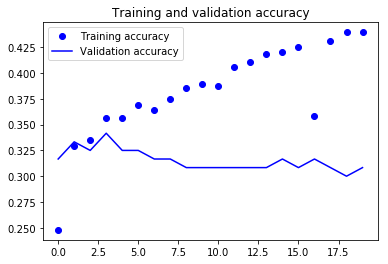

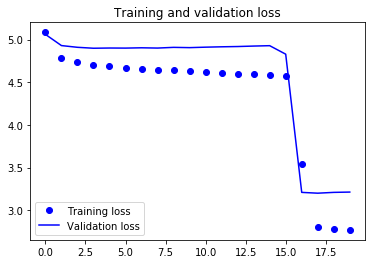

In [56]:
#let's plot accuracy over number of epochs

accuracy_onelayer = model2_train.history['acc']
val_accuracy_onelayer = model2_train.history['val_acc']
loss_onelayer = model2_train.history['loss']
val_loss_onelayer = model2_train.history['val_loss']
epochs_onelayer = range(len(accuracy_onelayer))
plt.plot(epochs_onelayer, accuracy_onelayer, 'bo', label='Training accuracy')
plt.plot(epochs_onelayer, val_accuracy_onelayer, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs_onelayer, loss_onelayer, 'bo', label='Training loss')
plt.plot(epochs_onelayer, val_loss_onelayer, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [57]:
#two layers

batch_size_twolayers = 16
epochs_twolayers = 20
num_classes_twolayers = 8

model2_twolayers = Sequential()
model2_twolayers.add(Conv2D(22, kernel_size=(2, 1),activation='linear',input_shape=(2,22,1),padding='same'))
model2_twolayers.add(LeakyReLU(alpha=0.1))
model2_twolayers.add(MaxPooling2D((1,1),padding='same'))
model2_twolayers.add(Conv2D(44, (2, 1), activation='linear',padding='same'))
model2_twolayers.add(LeakyReLU(alpha=0.1))
model2_twolayers.add(MaxPooling2D(pool_size=(2, 1),padding='same'))
#model2.add(Conv2D(128, (2, 1), activation='linear',padding='same'))
#model2.add(LeakyReLU(alpha=0.1))                  
#model2.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model2_twolayers.add(Flatten())
model2_twolayers.add(Dense(44, activation='linear'))
model2_twolayers.add(LeakyReLU(alpha=0.1))                  
model2_twolayers.add(Dense(num_classes, activation='softmax'))

model2_twolayers.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])



In [58]:
model2_twolayers.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 2, 22, 22)         66        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 2, 22, 22)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 22, 22)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 22, 44)         1980      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 2, 22, 44)         0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 22, 44)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 968)               0         
__________

In [59]:
model2_twolayers_train = model2_twolayers.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label), shuffle = False)

Train on 480 samples, validate on 120 samples
Epoch 1/20
480/480 [==============================] - 0s 908us/step - loss: 3.3606 - acc: 0.2937 - val_loss: 3.3911 - val_acc: 0.3417
Epoch 2/20
480/480 [==============================] - 0s 192us/step - loss: 3.0105 - acc: 0.3063 - val_loss: 3.3230 - val_acc: 0.3333
Epoch 3/20
480/480 [==============================] - 0s 196us/step - loss: 2.9669 - acc: 0.3208 - val_loss: 3.2370 - val_acc: 0.3333
Epoch 4/20
480/480 [==============================] - 0s 203us/step - loss: 2.9125 - acc: 0.3396 - val_loss: 3.2217 - val_acc: 0.3250
Epoch 5/20
480/480 [==============================] - 0s 200us/step - loss: 2.8873 - acc: 0.3583 - val_loss: 3.2210 - val_acc: 0.3167
Epoch 6/20
480/480 [==============================] - 0s 196us/step - loss: 2.8678 - acc: 0.3708 - val_loss: 3.2131 - val_acc: 0.3167
Epoch 7/20
480/480 [==============================] - 0s 196us/step - loss: 2.8496 - acc: 0.3833 - val_loss: 3.2069 - val_acc: 0.3250
Epoch 8/20
480/4

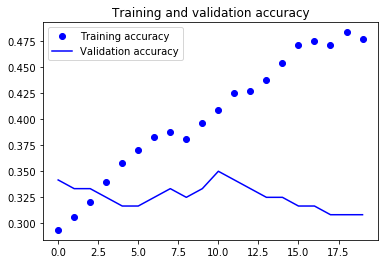

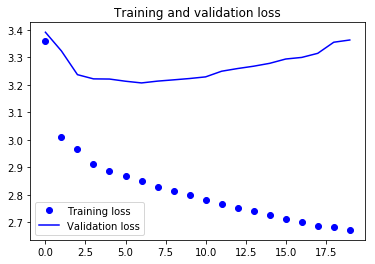

In [60]:
#let's plot accuracy over number of epochs

accuracy = model2_twolayers_train.history['acc']
val_accuracy = model2_twolayers_train.history['val_acc']
loss = model2_twolayers_train.history['loss']
val_loss = model2_twolayers_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [61]:
#2018 win_differential predictions

test_2018 = test_data_2018['2_tensor_vec']
test_data = test_2018.apply(lambda x: [i for i in chain.from_iterable([x[0].tolist(),
                                                               x[1].tolist()])])

test_data = np.array(list(test_data), dtype = np.float)

test_data = test_data.reshape(-1,2,22,1)

y_proba = model2.predict(test_data)
print("prob. values are")
print(y_proba)

y_classes = model2.predict_classes(test_data)
print()
print("corresponding classes are")
print(y_classes)


def to_win_differential(cls):
    if cls >= 4:
        return 1*(cls - 3)
    else:
        return 1*(cls - 4)

print()
print("corresponding win differentials are")
print([to_win_differential(i) for i in y_classes])

prob. values are
[[3.35067354e-18 1.14061496e-16 2.29838072e-17 1.54324713e-11
  4.38571109e-13 4.73123580e-01 2.12983593e-01 3.13892812e-01]
 [3.24205976e-18 1.00199458e-16 8.00448617e-18 8.44094586e-12
  5.01530675e-13 4.28242207e-01 2.05341220e-01 3.66416574e-01]
 [5.60180690e-18 1.64184102e-16 6.83087942e-18 1.20573083e-11
  7.24979321e-13 4.30276632e-01 2.16360807e-01 3.53362560e-01]
 [2.85647220e-18 9.16547155e-17 8.22465104e-18 7.95531696e-12
  4.04673338e-13 4.46285963e-01 2.35261410e-01 3.18452597e-01]
 [2.76692370e-18 9.26811407e-17 5.23777505e-18 7.91636721e-12
  4.26643801e-13 4.16968286e-01 1.93408132e-01 3.89623553e-01]
 [1.40164349e-18 5.85097736e-17 4.73260924e-18 7.43842141e-12
  1.82495701e-13 4.19318378e-01 1.53300062e-01 4.27381575e-01]
 [4.14991840e-18 1.27527494e-16 8.69319923e-18 1.31212107e-11
  5.44902990e-13 4.58119094e-01 1.97204500e-01 3.44676465e-01]
 [1.65528860e-18 5.84266651e-17 1.33304416e-17 1.47972658e-11
  2.19838023e-13 4.88866568e-01 1.61176041e-01

In [62]:
def predict_results2(model, test_data, predictor, eg):
    
    #here predictor can be stats_vec or 2_tensor
    #because of time restrictions we will look at stats_vec first
    
    vec = test_data[predictor]
    vec = vec.apply(lambda x: [i for i in chain.from_iterable([x[0].tolist(),
                                                               x[1].tolist()])])
    
    vec = np.array(list(vec), dtype = np.float)
    vec = vec.reshape(-1,2,22,1)
    y_classes = model.predict_classes(vec)
    
    
    #this line will replace the line below
    round1_pred = [to_win_differential(i) for i in y_classes]
    

    
    result_dic = {}
    result_dic['Team1'] = test_data['Team1']
    result_dic['Team2'] = test_data['Team2']
    result_dic['pred_win_differential'] = round1_pred
    result_dic['actual_win_differential'] = test_data['win_differential']
    result_dic['Round'] = test_data['Round']

    round1_df = pd.DataFrame(result_dic).reset_index().drop(['index'], axis = 1)
    
    round1_df = round1_df[['Round','Team1','Team2','pred_win_differential']]
    
    #now let's generate results for the conference semifinals
    semifinalists = round1_df.apply(lambda x: x['Team1'] if x['pred_win_differential']>0 else x['Team2'], axis =1)
    
    team1 = []
    team2 = []

    for index, val in enumerate(semifinalists):
        
        
        if index < 2 :
            team1.append(val)
        elif index <4:
            team2.append(val)
        elif index < 6:
            team1.append(val)
        else: team2.append(val)
            
        

    semifinal_dic = {}

    semifinal_dic['Team1'] = team1
    semifinal_dic['Team2'] = team2

    semifinal_dic['Round'] = ['Eastern Conference Semifinals']*2 + ['Western Conference Semifinals']*2

    
    
    semifinal_dic['2_tensor_vec'] = [two_tensor(*tup, eg) for tup in zip(team1,team2)]

    #vec_semi = np.array(semifinal_dic['2_tensor_vec'], dtype = np.float)
    
    
    vec_semi = [i for i in chain.from_iterable(semifinal_dic['2_tensor_vec'])]
    
    
    
    
    vec_semi = np.array(list(vec_semi), dtype = np.float)
    
    vec_semi = vec_semi.reshape(-1,2,22,1)
    
    y_classes_semi = model.predict_classes(vec_semi)
    

    
    #this line will replace the line below
    semifinal_pred = [to_win_differential(i) for i in y_classes_semi]
    
    


    #semifinal_pred = model.predict(vec_semi)

    #semifinal_pred = vec_reshape(model, semifinal_dic)
    
    semifinal_dic['pred_win_differential'] = semifinal_pred

    semifinal_df = pd.DataFrame(semifinal_dic)
    
    semifinal_df = semifinal_df[['Round','Team1','Team2','pred_win_differential']]
    
    #conference finals
    
    conf_finalists = semifinal_df.apply(lambda x: x['Team1'] if x['pred_win_differential']>0 else x['Team2'], axis =1)    
    
    team1_conf = []
    team2_conf = []

    for index, val in enumerate(conf_finalists):
        if index%2 == 0 :
            team1_conf.append(val)
        else:
            team2_conf.append(val)
        
    conf_final_dic = {}

    conf_final_dic['Team1'] = team1_conf
    conf_final_dic['Team2'] = team2_conf

    conf_final_dic['Round'] = ['Eastern Conference Finals'] + ['Western Conference Finals']


    conf_final_dic['2_tensor_vec'] = [two_tensor(*tup, eg) for tup in zip(team1_conf,team2_conf)]

    vec_conffinal = [i for i in chain.from_iterable(conf_final_dic['2_tensor_vec'])]
    
    
    
    
    vec_conffinal = np.array(list(vec_conffinal), dtype = np.float)
    
    vec_conffinal = vec_conffinal.reshape(-1,2,22,1)
    
    y_classes_conffinal = model.predict_classes(vec_conffinal)
    

    
    #this line will replace the line below
    conffinal_pred = [to_win_differential(i) for i in y_classes_conffinal]

    #vec_conffinal = np.array(conf_final_dic['stats_vec'], dtype = np.float)
    
    
   
    #conffinal_pred = model.predict(vec_conffinal)

    conf_final_dic['pred_win_differential'] = conffinal_pred

    conf_final_df = pd.DataFrame(conf_final_dic)
    
    conf_final_df = conf_final_df[['Round','Team1','Team2','pred_win_differential']]
    
    #finally, the final! lol!
    
    finalists = conf_final_df.apply(lambda x: x['Team1'] if x['pred_win_differential']>0 else x['Team2'], axis =1)  
    
    team1_final = []
    team2_final = []
    
    for index, val in enumerate(finalists):
        if index%2 == 0 :
            team1_final.append(val)
        else: team2_final.append(val)
    
    final_dic = {}

    final_dic['Team1'] = team1_final
    final_dic['Team2'] = team2_final

    final_dic['Round'] = ['Final']


    final_dic['2_tensor_vec'] = [two_tensor(*tup, eg) for tup in zip(team1_final,team2_final)]
    
    
    vec_final = [i for i in chain.from_iterable(final_dic['2_tensor_vec'])]
    
    
    
    
    vec_final = np.array(list(vec_final), dtype = np.float)
    
    vec_final = vec_final.reshape(-1,2,22,1)
    
    y_classes_final = model.predict_classes(vec_final)
    

    
    #this line will replace the line below
    final_pred = [to_win_differential(i) for i in y_classes_final]


    #vec_final = np.array(final_dic['stats_vec'], dtype = np.float)

    #final_pred = model.predict(vec_final)

    final_dic['pred_win_differential'] = final_pred

    final_df = pd.DataFrame(final_dic)
    
    final_df = final_df[['Round','Team1','Team2','pred_win_differential']]
            
    return pd.concat([final_df, conf_final_df, semifinal_df, round1_df]).reset_index().drop(['index'], axis = 1)


In [63]:
#test


pred_2018_v2 = predict_results2(model2, test_data_2018, '2_tensor_vec', reg_season_2018)

In [64]:
pred_2018_v2['Score'] = pred_2018_v2.pred_win_differential.apply(lambda x: 
                                                            '4' + '-' + str(4-x) if x>0 else str(4+x) + '-' + str(4) )

pred_2018_v2['winning_team'] = pred_2018_v2.apply(lambda x: x['Team1'] if x['pred_win_differential'] > 0 else x['Team2'], axis = 1)

pred_2018_v2

,Round,Team1,Team2,pred_win_differential,Score,winning_team
0,Final,Boston Celtics,Golden State Warriors,2,4-2,Boston Celtics
1,Eastern Conference Finals,Boston Celtics,Cleveland Cavaliers,2,4-2,Boston Celtics
2,Western Conference Finals,Golden State Warriors,Houston Rockets,2,4-2,Golden State Warriors
3,Eastern Conference Semifinals,Boston Celtics,Philadelphia 76ers,2,4-2,Boston Celtics
4,Eastern Conference Semifinals,Cleveland Cavaliers,Toronto Raptors,2,4-2,Cleveland Cavaliers
5,Western Conference Semifinals,Golden State Warriors,New Orleans Pelicans,2,4-2,Golden State Warriors
6,Western Conference Semifinals,Houston Rockets,Utah Jazz,4,4-0,Houston Rockets
7,Eastern Conference First Round,Boston Celtics,Milwaukee Bucks,2,4-2,Boston Celtics
8,Eastern Conference First Round,Cleveland Cavaliers,Indiana Pacers,2,4-2,Cleveland Cavaliers
9,Eastern Conference First Round,Philadelphia 76ers,Miami Heat,2,4-2,Philadelphia 76ers


In [65]:
#test two layers


pred_2018_v2_twolayers = predict_results2(model2_twolayers, test_data_2018, '2_tensor_vec', reg_season_2018)

In [66]:
#two layers

pred_2018_v2_twolayers['Score'] = pred_2018_v2_twolayers.pred_win_differential.apply(lambda x: 
                                                            '4' + '-' + str(4-x) if x>0 else str(4+x) + '-' + str(4) )

pred_2018_v2_twolayers['winning_team'] = pred_2018_v2_twolayers.apply(lambda x: x['Team1'] if x['pred_win_differential'] > 0 else x['Team2'], axis = 1)

pred_2018_v2_twolayers

,Round,Team1,Team2,pred_win_differential,Score,winning_team
0,Final,Boston Celtics,Golden State Warriors,2,4-2,Boston Celtics
1,Eastern Conference Finals,Boston Celtics,Cleveland Cavaliers,2,4-2,Boston Celtics
2,Western Conference Finals,Golden State Warriors,Houston Rockets,2,4-2,Golden State Warriors
3,Eastern Conference Semifinals,Boston Celtics,Philadelphia 76ers,2,4-2,Boston Celtics
4,Eastern Conference Semifinals,Cleveland Cavaliers,Toronto Raptors,2,4-2,Cleveland Cavaliers
5,Western Conference Semifinals,Golden State Warriors,New Orleans Pelicans,2,4-2,Golden State Warriors
6,Western Conference Semifinals,Houston Rockets,Utah Jazz,2,4-2,Houston Rockets
7,Eastern Conference First Round,Boston Celtics,Milwaukee Bucks,2,4-2,Boston Celtics
8,Eastern Conference First Round,Cleveland Cavaliers,Indiana Pacers,2,4-2,Cleveland Cavaliers
9,Eastern Conference First Round,Philadelphia 76ers,Miami Heat,2,4-2,Philadelphia 76ers


### Bracket Results (Method 2)

#### One Layer 

In [67]:
merged2 = pred_2018_v2[['Round','Team1','Team2','winning_team']]

merged2['actual_Team1'] = result_2018['Team1']

merged2['actual_Team2'] = result_2018['Team2']

merged2['actual_winning_team'] = result_2018['actual_winning_team']

merged2

,Round,Team1,Team2,winning_team,actual_Team1,actual_Team2,actual_winning_team
0,Final,Boston Celtics,Golden State Warriors,Boston Celtics,Golden State Warriors,Cleveland Cavaliers,Golden State Warriors
1,Eastern Conference Finals,Boston Celtics,Cleveland Cavaliers,Boston Celtics,Cleveland Cavaliers,Boston Celtics,Cleveland Cavaliers
2,Western Conference Finals,Golden State Warriors,Houston Rockets,Golden State Warriors,Golden State Warriors,Houston Rockets,Golden State Warriors
3,Eastern Conference Semifinals,Boston Celtics,Philadelphia 76ers,Boston Celtics,Boston Celtics,Philadelphia 76ers,Boston Celtics
4,Eastern Conference Semifinals,Cleveland Cavaliers,Toronto Raptors,Cleveland Cavaliers,Cleveland Cavaliers,Toronto Raptors,Cleveland Cavaliers
5,Western Conference Semifinals,Golden State Warriors,New Orleans Pelicans,Golden State Warriors,Golden State Warriors,New Orleans Pelicans,Golden State Warriors
6,Western Conference Semifinals,Houston Rockets,Utah Jazz,Houston Rockets,Houston Rockets,Utah Jazz,Houston Rockets
7,Eastern Conference First Round,Boston Celtics,Milwaukee Bucks,Boston Celtics,Boston Celtics,Milwaukee Bucks,Boston Celtics
8,Eastern Conference First Round,Cleveland Cavaliers,Indiana Pacers,Cleveland Cavaliers,Cleveland Cavaliers,Indiana Pacers,Cleveland Cavaliers
9,Eastern Conference First Round,Philadelphia 76ers,Miami Heat,Philadelphia 76ers,Philadelphia 76ers,Miami Heat,Philadelphia 76ers


### Accuracy

Although our second method predicts the eventual champion team incorrectly (Celtics win the championship), the overall accuracy is slightly better. The championship finalists are predicted incorrectly yielding a total of two incorrect predictions. So the accuracy is 13/15 or approximately 0.87.

#### Two layers 

In [68]:
merged2_twolayers = pred_2018_v2_twolayers[['Round','Team1','Team2','winning_team']]

merged2_twolayers['actual_Team1'] = result_2018['Team1']

merged2_twolayers['actual_Team2'] = result_2018['Team2']

merged2_twolayers['actual_winning_team'] = result_2018['actual_winning_team']

merged2_twolayers

,Round,Team1,Team2,winning_team,actual_Team1,actual_Team2,actual_winning_team
0,Final,Boston Celtics,Golden State Warriors,Boston Celtics,Golden State Warriors,Cleveland Cavaliers,Golden State Warriors
1,Eastern Conference Finals,Boston Celtics,Cleveland Cavaliers,Boston Celtics,Cleveland Cavaliers,Boston Celtics,Cleveland Cavaliers
2,Western Conference Finals,Golden State Warriors,Houston Rockets,Golden State Warriors,Golden State Warriors,Houston Rockets,Golden State Warriors
3,Eastern Conference Semifinals,Boston Celtics,Philadelphia 76ers,Boston Celtics,Boston Celtics,Philadelphia 76ers,Boston Celtics
4,Eastern Conference Semifinals,Cleveland Cavaliers,Toronto Raptors,Cleveland Cavaliers,Cleveland Cavaliers,Toronto Raptors,Cleveland Cavaliers
5,Western Conference Semifinals,Golden State Warriors,New Orleans Pelicans,Golden State Warriors,Golden State Warriors,New Orleans Pelicans,Golden State Warriors
6,Western Conference Semifinals,Houston Rockets,Utah Jazz,Houston Rockets,Houston Rockets,Utah Jazz,Houston Rockets
7,Eastern Conference First Round,Boston Celtics,Milwaukee Bucks,Boston Celtics,Boston Celtics,Milwaukee Bucks,Boston Celtics
8,Eastern Conference First Round,Cleveland Cavaliers,Indiana Pacers,Cleveland Cavaliers,Cleveland Cavaliers,Indiana Pacers,Cleveland Cavaliers
9,Eastern Conference First Round,Philadelphia 76ers,Miami Heat,Philadelphia 76ers,Philadelphia 76ers,Miami Heat,Philadelphia 76ers


We obtain the same bracket as the one layer!